In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 93 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 30.6 MB 18 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [3]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [4]:
tqdm = partial(tqdm, position=0, leave=True)

In [5]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/geotagged-images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/geotagged-images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [6]:
print(len(files_all))

297


In [7]:
from multiprocessing import Pool

In [8]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [9]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.5,fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [01:27<00:00,  1.45s/it]


In [10]:
Dataset = 'Small Village Dataset'

In [11]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 7.56573224067688 [s] ... size 1445.218304 MB


In [ ]:
'''f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

In [12]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [13]:
from timeit import default_timer as timer

In [14]:
time_all = []

In [15]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [16]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:33<00:00,  1.80it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 378149.12it/s]


In [ ]:
'''all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 160342.94it/s]


In [ ]:
'''all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [06:16<00:00,  6.27s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 315756.89it/s]


In [ ]:
'''all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 145341.17it/s]


In [ ]:
'''all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
''''start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:09<00:00,  6.28it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 95596.67it/s]


In [ ]:
'''all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [17]:
start = timer()

Threshl=80;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:26<00:00,  2.23it/s]


In [18]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 397250.58it/s]


In [ ]:
'''all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [19]:
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 80)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:59<00:00,  1.01it/s]


In [20]:
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 395378.22it/s]


In [ ]:
'''all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_agast_left

In [ ]:
''''import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_agast_right

FAST + SIFT

In [21]:

start = timer()


fast = cv2.FastFeatureDetector_create(threshold=80)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:56<00:00,  1.07it/s]


In [22]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 436149.46it/s]


In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [23]:

print(len(left_files_path))

61


In [24]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [25]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=6)
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:13<00:00,  2.23s/it]


In [26]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 163149.59it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [27]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 4, hessianThreshold = 60 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:48<00:00,  3.81s/it]


In [28]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 419430.40it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:08<00:00,  2.14s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 49388.33it/s]


In [ ]:
'''all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [29]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [30]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [31]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [32]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005538225173950195 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005404472351074219 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [33]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:07,  7.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 119
Number of Robust matches 46



Number of matches 1000
Number of matches After Lowe's Ratio 108
Number of Robust matches 42




  7%|▋         | 4/61 [00:00<00:07,  7.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 46



Number of matches 1000
Number of matches After Lowe's Ratio 181
Number of Robust matches 87




 10%|▉         | 6/61 [00:00<00:06,  8.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 50



Number of matches 1001
Number of matches After Lowe's Ratio 150
Number of Robust matches 106




 13%|█▎        | 8/61 [00:00<00:06,  8.57it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 148
Number of Robust matches 93



Number of matches 1000
Number of matches After Lowe's Ratio 161
Number of Robust matches 86




 16%|█▋        | 10/61 [00:01<00:05,  8.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 181
Number of Robust matches 98



Number of matches 1000
Number of matches After Lowe's Ratio 137
Number of Robust matches 57




 20%|█▉        | 12/61 [00:01<00:05,  8.39it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 40



Number of matches 1000
Number of matches After Lowe's Ratio 159
Number of Robust matches 49




 23%|██▎       | 14/61 [00:01<00:05,  8.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 18
Number of Robust matches 13


Number of matches After Lowe's Ratio New 51
Number of Robust matches New 16




 26%|██▌       | 16/61 [00:01<00:05,  8.12it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 39
Number of Robust matches 21


Number of matches After Lowe's Ratio New 79
Number of Robust matches New 22



Number of matches 1000
Number of matches After Lowe's Ratio 119
Number of Robust matches 48




 30%|██▉       | 18/61 [00:02<00:05,  8.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 58



Number of matches 1000
Number of matches After Lowe's Ratio 116
Number of Robust matches 43




 33%|███▎      | 20/61 [00:02<00:04,  8.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 46



Number of matches 1000
Number of matches After Lowe's Ratio 113
Number of Robust matches 60




 36%|███▌      | 22/61 [00:02<00:04,  9.22it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 136
Number of Robust matches 91



Number of matches 1000
Number of matches After Lowe's Ratio 167
Number of Robust matches 109



Number of matches 1000
Number of matches After Lowe's Ratio 156


 39%|███▉      | 24/61 [00:02<00:04,  9.01it/s]

Number of Robust matches 115



Number of matches 1000
Number of matches After Lowe's Ratio 106
Number of Robust matches 42




 43%|████▎     | 26/61 [00:03<00:04,  7.54it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 103
Number of Robust matches 50



Number of matches 1000
Number of matches After Lowe's Ratio 54
Number of Robust matches 17


Number of matches After Lowe's Ratio New 136
Number of Robust matches New 16




 46%|████▌     | 28/61 [00:03<00:04,  7.66it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 157
Number of Robust matches 45



Number of matches 1000
Number of matches After Lowe's Ratio 71
Number of Robust matches 27




 48%|████▊     | 29/61 [00:03<00:04,  6.95it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 16
Number of Robust matches 7


Number of matches After Lowe's Ratio New 60
Number of Robust matches New 11



Number of matches 1002
Number of matches After Lowe's Ratio 23
Number of Robust matches 11


Number of matches After Lowe's Ratio New 79


 51%|█████     | 31/61 [00:03<00:04,  6.28it/s]

Number of Robust matches New 12



Number of matches 1001
Number of matches After Lowe's Ratio 77
Number of Robust matches 24


Number of matches After Lowe's Ratio New 135
Number of Robust matches New 34




 52%|█████▏    | 32/61 [00:04<00:04,  6.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 139
Number of Robust matches 44



Number of matches 1000
Number of matches After Lowe's Ratio 117
Number of Robust matches 55




 57%|█████▋    | 35/61 [00:04<00:03,  8.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 129
Number of Robust matches 51



Number of matches 1000
Number of matches After Lowe's Ratio 107
Number of Robust matches 54




 61%|██████    | 37/61 [00:04<00:02,  8.54it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 119
Number of Robust matches 59



Number of matches 1000
Number of matches After Lowe's Ratio 125
Number of Robust matches 74




 64%|██████▍   | 39/61 [00:04<00:02,  8.80it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 185
Number of Robust matches 105



Number of matches 1000
Number of matches After Lowe's Ratio 194
Number of Robust matches 125




 67%|██████▋   | 41/61 [00:05<00:02,  8.50it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 68
Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 101
Number of Robust matches 34




 70%|███████   | 43/61 [00:05<00:02,  8.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 73



Number of matches 1000
Number of matches After Lowe's Ratio 106
Number of Robust matches 33




 72%|███████▏  | 44/61 [00:05<00:02,  7.41it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 12
Number of Robust matches 6


Number of matches After Lowe's Ratio New 50
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 9
Number of Robust matches 5


Number of matches After Lowe's Ratio New 62


 75%|███████▌  | 46/61 [00:05<00:02,  6.32it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 12
Number of Robust matches 8


Number of matches After Lowe's Ratio New 45
Number of Robust matches New 9




 77%|███████▋  | 47/61 [00:05<00:02,  6.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 22
Number of Robust matches 8


Number of matches After Lowe's Ratio New 74
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 23


Number of matches After Lowe's Ratio New 189


 80%|████████  | 49/61 [00:06<00:01,  6.51it/s]

Number of Robust matches New 28



Number of matches 1000
Number of matches After Lowe's Ratio 108
Number of Robust matches 42




 84%|████████▎ | 51/61 [00:06<00:01,  7.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 105
Number of Robust matches 41



Number of matches 1000
Number of matches After Lowe's Ratio 68
Number of Robust matches 42




 87%|████████▋ | 53/61 [00:06<00:00,  8.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 97



Number of matches 1001
Number of matches After Lowe's Ratio 185
Number of Robust matches 151




 90%|█████████ | 55/61 [00:06<00:00,  8.78it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 238
Number of Robust matches 203



Number of matches 1000
Number of matches After Lowe's Ratio 193
Number of Robust matches 173




 93%|█████████▎| 57/61 [00:07<00:00,  8.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 72



Number of matches 1000
Number of matches After Lowe's Ratio 119
Number of Robust matches 53




 95%|█████████▌| 58/61 [00:07<00:00,  8.79it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 138
Number of Robust matches 54



Number of matches 1000
Number of matches After Lowe's Ratio 100
Number of Robust matches 48




 98%|█████████▊| 60/61 [00:07<00:00,  8.01it/s]



Number of matches 1000
Number of matches After Lowe's Ratio 21
Number of Robust matches 12


Number of matches After Lowe's Ratio New 61
Number of Robust matches New 24




  2%|▏         | 1/60 [00:00<00:06,  8.98it/s]


Number of matches 1002
Number of matches After Lowe's Ratio 99
Number of Robust matches 49




  3%|▎         | 2/60 [00:00<00:06,  9.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 74
Number of Robust matches 38




  5%|▌         | 3/60 [00:00<00:06,  8.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 32




  7%|▋         | 4/60 [00:00<00:06,  8.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 104
Number of Robust matches 46




  8%|▊         | 5/60 [00:00<00:06,  8.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 60




 10%|█         | 6/60 [00:00<00:06,  8.65it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 128
Number of Robust matches 47




 12%|█▏        | 7/60 [00:00<00:06,  8.82it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 139
Number of Robust matches 55




 13%|█▎        | 8/60 [00:00<00:05,  8.98it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 92




 15%|█▌        | 9/60 [00:01<00:05,  8.95it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 201
Number of Robust matches 115




 17%|█▋        | 10/60 [00:01<00:05,  8.88it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 162
Number of Robust matches 101




 18%|█▊        | 11/60 [00:01<00:05,  8.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 182
Number of Robust matches 140




 20%|██        | 12/60 [00:01<00:05,  8.31it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 105
Number of Robust matches 50




 22%|██▏       | 13/60 [00:01<00:05,  8.24it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 125
Number of Robust matches 72




 23%|██▎       | 14/60 [00:01<00:06,  7.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 141
Number of Robust matches 61




 25%|██▌       | 15/60 [00:01<00:06,  7.50it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 39




 27%|██▋       | 16/60 [00:01<00:06,  7.17it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 44




 28%|██▊       | 17/60 [00:02<00:05,  7.61it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 41




 30%|███       | 18/60 [00:02<00:05,  8.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 68




 32%|███▏      | 19/60 [00:02<00:04,  8.42it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 53
Number of Robust matches 30




 33%|███▎      | 20/60 [00:02<00:04,  8.36it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 38




 35%|███▌      | 21/60 [00:02<00:04,  8.50it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 68




 37%|███▋      | 22/60 [00:02<00:04,  8.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 148
Number of Robust matches 58




 38%|███▊      | 23/60 [00:02<00:04,  8.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 167
Number of Robust matches 73




 40%|████      | 24/60 [00:02<00:03,  9.03it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 193
Number of Robust matches 116




 42%|████▏     | 25/60 [00:02<00:03,  9.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 147
Number of Robust matches 85




 43%|████▎     | 26/60 [00:03<00:03,  9.21it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 93




 45%|████▌     | 27/60 [00:03<00:03,  9.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 145
Number of Robust matches 112




 47%|████▋     | 28/60 [00:03<00:03,  9.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 75
Number of Robust matches 46




 48%|████▊     | 29/60 [00:03<00:03,  8.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 66




 50%|█████     | 30/60 [00:03<00:03,  9.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 169
Number of Robust matches 79




 52%|█████▏    | 31/60 [00:03<00:03,  9.21it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 144
Number of Robust matches 59




 53%|█████▎    | 32/60 [00:03<00:03,  8.42it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 139
Number of Robust matches 59




 55%|█████▌    | 33/60 [00:03<00:03,  8.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 172
Number of Robust matches 89




 58%|█████▊    | 35/60 [00:04<00:02,  9.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 57
Number of Robust matches 41



Number of matches 1001
Number of matches After Lowe's Ratio 50
Number of Robust matches 27



Number of matches 1001
Number of matches After Lowe's Ratio 118


 62%|██████▏   | 37/60 [00:04<00:02,  9.02it/s]

Number of Robust matches 60



Number of matches 1000
Number of matches After Lowe's Ratio 160
Number of Robust matches 76




 65%|██████▌   | 39/60 [00:04<00:02,  8.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 55



Number of matches 1000
Number of matches After Lowe's Ratio 173
Number of Robust matches 75




 67%|██████▋   | 40/60 [00:04<00:02,  9.06it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 185
Number of Robust matches 112



Number of matches 1000
Number of matches After Lowe's Ratio 81
Number of Robust matches 51




 72%|███████▏  | 43/60 [00:04<00:01,  9.29it/s]


Number of matches 1002
Number of matches After Lowe's Ratio 56
Number of Robust matches 48



Number of matches 1000
Number of matches After Lowe's Ratio 51
Number of Robust matches 41




 75%|███████▌  | 45/60 [00:05<00:01,  9.32it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 91
Number of Robust matches 71



Number of matches 1000
Number of matches After Lowe's Ratio 134
Number of Robust matches 74




 78%|███████▊  | 47/60 [00:05<00:01,  9.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 155
Number of Robust matches 82



Number of matches 1001
Number of matches After Lowe's Ratio 133
Number of Robust matches 47




 80%|████████  | 48/60 [00:05<00:01,  8.81it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 113
Number of Robust matches 45



Number of matches 1000
Number of matches After Lowe's Ratio 67
Number of Robust matches 37




 85%|████████▌ | 51/60 [00:05<00:00,  9.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 92
Number of Robust matches 42



Number of matches 1000
Number of matches After Lowe's Ratio 104
Number of Robust matches 51




 88%|████████▊ | 53/60 [00:06<00:00,  8.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 55
Number of Robust matches 24


Number of matches After Lowe's Ratio New 128
Number of Robust matches New 30



Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 31




 92%|█████████▏| 55/60 [00:06<00:00,  8.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 54



Number of matches 1000
Number of matches After Lowe's Ratio 196
Number of Robust matches 94




 95%|█████████▌| 57/60 [00:06<00:00,  8.61it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 153
Number of Robust matches 90



Number of matches 1000
Number of matches After Lowe's Ratio 183
Number of Robust matches 148




 98%|█████████▊| 59/60 [00:06<00:00,  8.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 197
Number of Robust matches 170



Number of matches 1000
Number of matches After Lowe's Ratio 232
Number of Robust matches 215




In [34]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009578704833984375 [s] ... size 0.006368 MB


In [35]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00612950325012207 [s] ... size 0.006296 MB


In [36]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [37]:

H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  2%|▏         | 1/61 [00:02<02:09,  2.15s/it]


Number of matches 11272
Number of matches After Lowe's Ratio 3383
Number of Robust matches 1391




  3%|▎         | 2/61 [00:03<01:51,  1.90s/it]


Number of matches 11726
Number of matches After Lowe's Ratio 4491
Number of Robust matches 1803




  5%|▍         | 3/61 [00:05<01:44,  1.81s/it]


Number of matches 9982
Number of matches After Lowe's Ratio 3478
Number of Robust matches 1327




  7%|▋         | 4/61 [00:06<01:33,  1.64s/it]


Number of matches 9457
Number of matches After Lowe's Ratio 3163
Number of Robust matches 1554




  8%|▊         | 5/61 [00:08<01:25,  1.52s/it]


Number of matches 8980
Number of matches After Lowe's Ratio 1482
Number of Robust matches 661




 10%|▉         | 6/61 [00:09<01:22,  1.50s/it]


Number of matches 11584
Number of matches After Lowe's Ratio 624
Number of Robust matches 11


Number of matches After Lowe's Ratio New 94
Number of Robust matches New 6




 11%|█▏        | 7/61 [00:11<01:24,  1.56s/it]


Number of matches 11011
Number of matches After Lowe's Ratio 4379
Number of Robust matches 2882



Number of matches 9024
Number of matches After Lowe's Ratio 3320


 13%|█▎        | 8/61 [00:13<01:26,  1.64s/it]

Number of Robust matches 1808




 15%|█▍        | 9/61 [00:14<01:19,  1.52s/it]


Number of matches 9709
Number of matches After Lowe's Ratio 3619
Number of Robust matches 1972




 16%|█▋        | 10/61 [00:15<01:15,  1.49s/it]


Number of matches 10193
Number of matches After Lowe's Ratio 3698
Number of Robust matches 1653




 18%|█▊        | 11/61 [00:17<01:13,  1.46s/it]


Number of matches 10585
Number of matches After Lowe's Ratio 2796
Number of Robust matches 964




 20%|█▉        | 12/61 [00:18<01:11,  1.46s/it]


Number of matches 9853
Number of matches After Lowe's Ratio 2800
Number of Robust matches 808




 21%|██▏       | 13/61 [00:20<01:13,  1.53s/it]


Number of matches 16992
Number of matches After Lowe's Ratio 1682
Number of Robust matches 214




 23%|██▎       | 14/61 [00:24<01:43,  2.21s/it]


Number of matches 27759
Number of matches After Lowe's Ratio 1072
Number of Robust matches 10


Number of matches After Lowe's Ratio New 148
Number of Robust matches New 7




 25%|██▍       | 15/61 [00:29<02:19,  3.02s/it]


Number of matches 12523
Number of matches After Lowe's Ratio 2391
Number of Robust matches 1405




 26%|██▌       | 16/61 [00:30<02:00,  2.67s/it]


Number of matches 9410
Number of matches After Lowe's Ratio 1593
Number of Robust matches 603




 28%|██▊       | 17/61 [00:32<01:40,  2.29s/it]


Number of matches 10275
Number of matches After Lowe's Ratio 773
Number of Robust matches 68




 30%|██▉       | 18/61 [00:33<01:29,  2.08s/it]


Number of matches 12026
Number of matches After Lowe's Ratio 777
Number of Robust matches 19


Number of matches After Lowe's Ratio New 208
Number of Robust matches New 9




 31%|███       | 19/61 [00:35<01:24,  2.02s/it]


Number of matches 10996
Number of matches After Lowe's Ratio 739
Number of Robust matches 14


Number of matches After Lowe's Ratio New 186
Number of Robust matches New 11




 33%|███▎      | 20/61 [00:37<01:18,  1.92s/it]


Number of matches 11097
Number of matches After Lowe's Ratio 801
Number of Robust matches 40




 34%|███▍      | 21/61 [00:39<01:14,  1.85s/it]


Number of matches 12608
Number of matches After Lowe's Ratio 855
Number of Robust matches 26




 36%|███▌      | 22/61 [00:41<01:19,  2.05s/it]


Number of matches 15723
Number of matches After Lowe's Ratio 1171
Number of Robust matches 18


Number of matches After Lowe's Ratio New 333
Number of Robust matches New 15




 38%|███▊      | 23/61 [00:44<01:22,  2.16s/it]


Number of matches 11531
Number of matches After Lowe's Ratio 896
Number of Robust matches 224




 39%|███▉      | 24/61 [00:45<01:15,  2.04s/it]


Number of matches 9078
Number of matches After Lowe's Ratio 559
Number of Robust matches 11


Number of matches After Lowe's Ratio New 148
Number of Robust matches New 10




 41%|████      | 25/61 [00:47<01:05,  1.83s/it]


Number of matches 8697
Number of matches After Lowe's Ratio 728
Number of Robust matches 43




 43%|████▎     | 26/61 [00:48<00:59,  1.69s/it]


Number of matches 11342
Number of matches After Lowe's Ratio 859
Number of Robust matches 14


Number of matches After Lowe's Ratio New 250
Number of Robust matches New 11




 44%|████▍     | 27/61 [00:50<00:58,  1.72s/it]


Number of matches 10403
Number of matches After Lowe's Ratio 587
Number of Robust matches 16


Number of matches After Lowe's Ratio New 152
Number of Robust matches New 14




 46%|████▌     | 28/61 [00:52<00:56,  1.71s/it]


Number of matches 11991
Number of matches After Lowe's Ratio 776
Number of Robust matches 26




 48%|████▊     | 29/61 [00:54<00:59,  1.87s/it]


Number of matches 19086
Number of matches After Lowe's Ratio 758
Number of Robust matches 9


Number of matches After Lowe's Ratio New 114
Number of Robust matches New 8




 49%|████▉     | 30/61 [00:57<01:14,  2.40s/it]


Number of matches 15903
Number of matches After Lowe's Ratio 1616
Number of Robust matches 572




 51%|█████     | 31/61 [01:00<01:13,  2.44s/it]


Number of matches 10870
Number of matches After Lowe's Ratio 1600
Number of Robust matches 466




 52%|█████▏    | 32/61 [01:02<01:03,  2.19s/it]


Number of matches 7235
Number of matches After Lowe's Ratio 989
Number of Robust matches 245




 54%|█████▍    | 33/61 [01:03<00:51,  1.85s/it]


Number of matches 8312
Number of matches After Lowe's Ratio 1586
Number of Robust matches 565




 56%|█████▌    | 34/61 [01:04<00:44,  1.66s/it]


Number of matches 8131
Number of matches After Lowe's Ratio 2013
Number of Robust matches 759




 57%|█████▋    | 35/61 [01:05<00:39,  1.52s/it]


Number of matches 9222
Number of matches After Lowe's Ratio 2091
Number of Robust matches 833




 59%|█████▉    | 36/61 [01:07<00:37,  1.50s/it]


Number of matches 11688
Number of matches After Lowe's Ratio 3230
Number of Robust matches 1588




 61%|██████    | 37/61 [01:08<00:39,  1.64s/it]


Number of matches 13790
Number of matches After Lowe's Ratio 1029
Number of Robust matches 42




 62%|██████▏   | 38/61 [01:11<00:41,  1.79s/it]


Number of matches 8693
Number of matches After Lowe's Ratio 2046
Number of Robust matches 1098




 64%|██████▍   | 39/61 [01:12<00:35,  1.60s/it]


Number of matches 5893
Number of matches After Lowe's Ratio 847
Number of Robust matches 465




 66%|██████▌   | 40/61 [01:13<00:28,  1.35s/it]


Number of matches 3716
Number of matches After Lowe's Ratio 945
Number of Robust matches 607




 67%|██████▋   | 41/61 [01:13<00:22,  1.11s/it]


Number of matches 4953
Number of matches After Lowe's Ratio 902
Number of Robust matches 308




 69%|██████▉   | 42/61 [01:14<00:19,  1.02s/it]


Number of matches 7644
Number of matches After Lowe's Ratio 880
Number of Robust matches 165




 70%|███████   | 43/61 [01:15<00:19,  1.11s/it]


Number of matches 12470
Number of matches After Lowe's Ratio 2350
Number of Robust matches 868




 72%|███████▏  | 44/61 [01:18<00:25,  1.52s/it]


Number of matches 19210
Number of matches After Lowe's Ratio 1464
Number of Robust matches 527




 74%|███████▍  | 45/61 [01:22<00:39,  2.49s/it]


Number of matches 30373
Number of matches After Lowe's Ratio 1099
Number of Robust matches 16


Number of matches After Lowe's Ratio New 144
Number of Robust matches New 7




 75%|███████▌  | 46/61 [01:28<00:51,  3.42s/it]


Number of matches 17820
Number of matches After Lowe's Ratio 666
Number of Robust matches 15


Number of matches After Lowe's Ratio New 116
Number of Robust matches New 12




 77%|███████▋  | 47/61 [01:31<00:45,  3.24s/it]


Number of matches 10114
Number of matches After Lowe's Ratio 1871
Number of Robust matches 1090




 79%|███████▊  | 48/61 [01:32<00:35,  2.70s/it]


Number of matches 8062
Number of matches After Lowe's Ratio 2569
Number of Robust matches 1245




 80%|████████  | 49/61 [01:33<00:26,  2.20s/it]


Number of matches 4077
Number of matches After Lowe's Ratio 1394
Number of Robust matches 463




 82%|████████▏ | 50/61 [01:34<00:18,  1.72s/it]


Number of matches 6201
Number of matches After Lowe's Ratio 1772
Number of Robust matches 838




 84%|████████▎ | 51/61 [01:35<00:14,  1.49s/it]


Number of matches 7530
Number of matches After Lowe's Ratio 2259
Number of Robust matches 1544




 85%|████████▌ | 52/61 [01:36<00:13,  1.48s/it]


Number of matches 10928
Number of matches After Lowe's Ratio 2942
Number of Robust matches 1893




 87%|████████▋ | 53/61 [01:38<00:12,  1.56s/it]


Number of matches 14607
Number of matches After Lowe's Ratio 1037
Number of Robust matches 124




 89%|████████▊ | 54/61 [01:41<00:12,  1.82s/it]


Number of matches 14409
Number of matches After Lowe's Ratio 5407
Number of Robust matches 3916




 90%|█████████ | 55/61 [01:43<00:11,  1.90s/it]


Number of matches 9782
Number of matches After Lowe's Ratio 1798
Number of Robust matches 1263




 92%|█████████▏| 56/61 [01:44<00:08,  1.73s/it]


Number of matches 7617
Number of matches After Lowe's Ratio 922
Number of Robust matches 500




 93%|█████████▎| 57/61 [01:45<00:06,  1.53s/it]


Number of matches 6432
Number of matches After Lowe's Ratio 1686
Number of Robust matches 771




 95%|█████████▌| 58/61 [01:46<00:04,  1.34s/it]


Number of matches 5432
Number of matches After Lowe's Ratio 922
Number of Robust matches 444




 97%|█████████▋| 59/61 [01:47<00:02,  1.21s/it]


Number of matches 11808
Number of matches After Lowe's Ratio 1565
Number of Robust matches 857




 98%|█████████▊| 60/61 [01:49<00:01,  1.83s/it]



Number of matches 19731
Number of matches After Lowe's Ratio 1771
Number of Robust matches 874




  2%|▏         | 1/60 [00:01<01:25,  1.45s/it]


Number of matches 12663
Number of matches After Lowe's Ratio 3458
Number of Robust matches 1274




  3%|▎         | 2/60 [00:03<01:50,  1.91s/it]


Number of matches 17343
Number of matches After Lowe's Ratio 3563
Number of Robust matches 1469




  5%|▌         | 3/60 [00:06<02:14,  2.36s/it]


Number of matches 11491
Number of matches After Lowe's Ratio 540
Number of Robust matches 22


Number of matches After Lowe's Ratio New 96
Number of Robust matches New 10




  7%|▋         | 4/60 [00:08<01:57,  2.10s/it]


Number of matches 10709
Number of matches After Lowe's Ratio 1025
Number of Robust matches 316




  8%|▊         | 5/60 [00:09<01:44,  1.91s/it]


Number of matches 10994
Number of matches After Lowe's Ratio 3547
Number of Robust matches 1441




 10%|█         | 6/60 [00:11<01:42,  1.89s/it]


Number of matches 11148
Number of matches After Lowe's Ratio 3983
Number of Robust matches 1649




 12%|█▏        | 7/60 [00:13<01:34,  1.78s/it]


Number of matches 9976
Number of matches After Lowe's Ratio 3982
Number of Robust matches 1814




 13%|█▎        | 8/60 [00:14<01:25,  1.64s/it]


Number of matches 8028
Number of matches After Lowe's Ratio 3290
Number of Robust matches 1746




 15%|█▌        | 9/60 [00:15<01:13,  1.45s/it]


Number of matches 6144
Number of matches After Lowe's Ratio 2569
Number of Robust matches 1401




 17%|█▋        | 10/60 [00:16<01:02,  1.25s/it]


Number of matches 5740
Number of matches After Lowe's Ratio 2084
Number of Robust matches 1345




 18%|█▊        | 11/60 [00:17<00:56,  1.15s/it]


Number of matches 6840
Number of matches After Lowe's Ratio 340
Number of Robust matches 11


Number of matches After Lowe's Ratio New 76
Number of Robust matches New 7




 20%|██        | 12/60 [00:18<00:53,  1.11s/it]


Number of matches 9564
Number of matches After Lowe's Ratio 2538
Number of Robust matches 1415




 22%|██▏       | 13/60 [00:19<00:56,  1.19s/it]


Number of matches 10607
Number of matches After Lowe's Ratio 4054
Number of Robust matches 2280




 23%|██▎       | 14/60 [00:21<00:59,  1.29s/it]


Number of matches 11246
Number of matches After Lowe's Ratio 4577
Number of Robust matches 2044




 25%|██▌       | 15/60 [00:23<01:06,  1.47s/it]


Number of matches 10886
Number of matches After Lowe's Ratio 3549
Number of Robust matches 1915




 27%|██▋       | 16/60 [00:24<01:05,  1.49s/it]


Number of matches 8585
Number of matches After Lowe's Ratio 3171
Number of Robust matches 1416




 28%|██▊       | 17/60 [00:25<01:00,  1.42s/it]


Number of matches 9356
Number of matches After Lowe's Ratio 2318
Number of Robust matches 965




 30%|███       | 18/60 [00:27<01:00,  1.44s/it]


Number of matches 11350
Number of matches After Lowe's Ratio 2790
Number of Robust matches 1254




 32%|███▏      | 19/60 [00:29<01:02,  1.53s/it]


Number of matches 8060
Number of matches After Lowe's Ratio 448
Number of Robust matches 21


Number of matches After Lowe's Ratio New 107
Number of Robust matches New 18




 33%|███▎      | 20/60 [00:30<00:58,  1.45s/it]


Number of matches 8641
Number of matches After Lowe's Ratio 1057
Number of Robust matches 396




 35%|███▌      | 21/60 [00:31<00:55,  1.42s/it]


Number of matches 12963
Number of matches After Lowe's Ratio 3756
Number of Robust matches 1927




 37%|███▋      | 22/60 [00:33<00:59,  1.56s/it]


Number of matches 11207
Number of matches After Lowe's Ratio 3754
Number of Robust matches 1603




 38%|███▊      | 23/60 [00:35<01:00,  1.63s/it]


Number of matches 9401
Number of matches After Lowe's Ratio 3956
Number of Robust matches 1943




 40%|████      | 24/60 [00:36<00:55,  1.54s/it]


Number of matches 8653
Number of matches After Lowe's Ratio 3748
Number of Robust matches 2275




 42%|████▏     | 25/60 [00:37<00:49,  1.42s/it]


Number of matches 6027
Number of matches After Lowe's Ratio 3056
Number of Robust matches 2237




 43%|████▎     | 26/60 [00:38<00:41,  1.21s/it]


Number of matches 2579
Number of matches After Lowe's Ratio 1458
Number of Robust matches 1053




 45%|████▌     | 27/60 [00:39<00:33,  1.01s/it]


Number of matches 4105
Number of matches After Lowe's Ratio 182
Number of Robust matches 8


Number of matches After Lowe's Ratio New 28
Number of Robust matches New 5




 47%|████▋     | 28/60 [00:39<00:29,  1.07it/s]


Number of matches 10573
Number of matches After Lowe's Ratio 2629
Number of Robust matches 1736




 48%|████▊     | 29/60 [00:41<00:35,  1.16s/it]


Number of matches 12737
Number of matches After Lowe's Ratio 4772
Number of Robust matches 2413




 50%|█████     | 30/60 [00:43<00:41,  1.39s/it]


Number of matches 13058
Number of matches After Lowe's Ratio 5267
Number of Robust matches 2400



Number of matches 12783
Number of matches After Lowe's Ratio 4478


 52%|█████▏    | 31/60 [00:45<00:48,  1.66s/it]

Number of Robust matches 1977




 53%|█████▎    | 32/60 [00:47<00:47,  1.70s/it]


Number of matches 9287
Number of matches After Lowe's Ratio 2939
Number of Robust matches 1473




 55%|█████▌    | 33/60 [00:48<00:42,  1.56s/it]


Number of matches 5930
Number of matches After Lowe's Ratio 2189
Number of Robust matches 1262




 57%|█████▋    | 34/60 [00:49<00:35,  1.38s/it]


Number of matches 12604
Number of matches After Lowe's Ratio 2033
Number of Robust matches 954




 58%|█████▊    | 35/60 [00:51<00:39,  1.57s/it]


Number of matches 8918
Number of matches After Lowe's Ratio 364
Number of Robust matches 6


Number of matches After Lowe's Ratio New 52
Number of Robust matches New 5




 60%|██████    | 36/60 [00:53<00:36,  1.51s/it]


Number of matches 8804
Number of matches After Lowe's Ratio 679
Number of Robust matches 146




 62%|██████▏   | 37/60 [00:54<00:33,  1.46s/it]


Number of matches 12391
Number of matches After Lowe's Ratio 3532
Number of Robust matches 1751




 63%|██████▎   | 38/60 [00:56<00:35,  1.61s/it]


Number of matches 13278
Number of matches After Lowe's Ratio 4683
Number of Robust matches 1962



Number of matches 10842
Number of matches After Lowe's Ratio 4828


 65%|██████▌   | 39/60 [00:58<00:38,  1.82s/it]

Number of Robust matches 2226




 67%|██████▋   | 40/60 [01:00<00:36,  1.80s/it]


Number of matches 11910
Number of matches After Lowe's Ratio 5017
Number of Robust matches 3524




 68%|██████▊   | 41/60 [01:02<00:34,  1.81s/it]


Number of matches 8127
Number of matches After Lowe's Ratio 3630
Number of Robust matches 2825




 72%|███████▏  | 43/60 [01:03<00:18,  1.11s/it]


Number of matches 74
Number of matches After Lowe's Ratio 25
Number of Robust matches 16


Number of matches After Lowe's Ratio New 20
Number of Robust matches New 13



Number of matches 6142
Number of matches After Lowe's Ratio 826
Number of Robust matches 277




 73%|███████▎  | 44/60 [01:04<00:17,  1.07s/it]


Number of matches 12050
Number of matches After Lowe's Ratio 3227
Number of Robust matches 2631




 75%|███████▌  | 45/60 [01:06<00:20,  1.34s/it]


Number of matches 13697
Number of matches After Lowe's Ratio 4683
Number of Robust matches 3090




 77%|███████▋  | 46/60 [01:08<00:22,  1.58s/it]


Number of matches 12189
Number of matches After Lowe's Ratio 4180
Number of Robust matches 2065




 78%|███████▊  | 47/60 [01:10<00:22,  1.72s/it]


Number of matches 10912
Number of matches After Lowe's Ratio 3407
Number of Robust matches 1301




 80%|████████  | 48/60 [01:12<00:19,  1.66s/it]


Number of matches 8598
Number of matches After Lowe's Ratio 2584
Number of Robust matches 1122




 82%|████████▏ | 49/60 [01:13<00:16,  1.53s/it]


Number of matches 4817
Number of matches After Lowe's Ratio 1495
Number of Robust matches 865




 83%|████████▎ | 50/60 [01:14<00:13,  1.30s/it]


Number of matches 9535
Number of matches After Lowe's Ratio 1916
Number of Robust matches 902




 85%|████████▌ | 51/60 [01:15<00:11,  1.33s/it]


Number of matches 5005
Number of matches After Lowe's Ratio 238
Number of Robust matches 23


Number of matches After Lowe's Ratio New 51
Number of Robust matches New 16




 87%|████████▋ | 52/60 [01:16<00:09,  1.19s/it]


Number of matches 9625
Number of matches After Lowe's Ratio 1652
Number of Robust matches 623




 88%|████████▊ | 53/60 [01:17<00:09,  1.30s/it]


Number of matches 10833
Number of matches After Lowe's Ratio 2909
Number of Robust matches 1005




 90%|█████████ | 54/60 [01:19<00:08,  1.40s/it]


Number of matches 12041
Number of matches After Lowe's Ratio 3810
Number of Robust matches 1778




 92%|█████████▏| 55/60 [01:21<00:07,  1.50s/it]


Number of matches 10438
Number of matches After Lowe's Ratio 3743
Number of Robust matches 1893




 93%|█████████▎| 56/60 [01:23<00:06,  1.58s/it]


Number of matches 9906
Number of matches After Lowe's Ratio 4112
Number of Robust matches 2228




 95%|█████████▌| 57/60 [01:24<00:04,  1.53s/it]


Number of matches 7531
Number of matches After Lowe's Ratio 3751
Number of Robust matches 2607




 97%|█████████▋| 58/60 [01:25<00:02,  1.35s/it]


Number of matches 2684
Number of matches After Lowe's Ratio 1757
Number of Robust matches 1630




 98%|█████████▊| 59/60 [01:25<00:01,  1.46s/it]


Number of matches 5039
Number of matches After Lowe's Ratio 205
Number of Robust matches 9


Number of matches After Lowe's Ratio New 28
Number of Robust matches New 6




In [38]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009735822677612305 [s] ... size 0.006368 MB


In [39]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011858463287353516 [s] ... size 0.006296 MB


In [40]:

del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004562854766845703 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004209756851196289 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0051157474517822266 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.007517576217651367 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0060634613037109375 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008934974670410156 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006726503372192383 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004112958908081055 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [41]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/61 [00:02<02:02,  2.05s/it]


Number of matches 11972
Number of matches After Lowe's Ratio 2545
Number of Robust matches 1358




  3%|▎         | 2/61 [00:03<01:50,  1.87s/it]


Number of matches 12405
Number of matches After Lowe's Ratio 3526
Number of Robust matches 1569




  5%|▍         | 3/61 [00:05<01:45,  1.81s/it]


Number of matches 10566
Number of matches After Lowe's Ratio 2555
Number of Robust matches 1271




  7%|▋         | 4/61 [00:06<01:35,  1.67s/it]


Number of matches 10002
Number of matches After Lowe's Ratio 2423
Number of Robust matches 1266




  8%|▊         | 5/61 [00:08<01:27,  1.57s/it]


Number of matches 9461
Number of matches After Lowe's Ratio 839
Number of Robust matches 470




 10%|▉         | 6/61 [00:10<01:31,  1.66s/it]


Number of matches 12246
Number of matches After Lowe's Ratio 99
Number of Robust matches 7


Number of matches After Lowe's Ratio New 99
Number of Robust matches New 7




 11%|█▏        | 7/61 [00:12<01:32,  1.72s/it]


Number of matches 11636
Number of matches After Lowe's Ratio 3674
Number of Robust matches 2527




 13%|█▎        | 8/61 [00:13<01:29,  1.69s/it]


Number of matches 9445
Number of matches After Lowe's Ratio 2596
Number of Robust matches 1498




 15%|█▍        | 9/61 [00:15<01:21,  1.57s/it]


Number of matches 10144
Number of matches After Lowe's Ratio 2849
Number of Robust matches 1549




 16%|█▋        | 10/61 [00:16<01:17,  1.53s/it]


Number of matches 10610
Number of matches After Lowe's Ratio 2904
Number of Robust matches 1606




 18%|█▊        | 11/61 [00:17<01:15,  1.52s/it]


Number of matches 11068
Number of matches After Lowe's Ratio 1873
Number of Robust matches 672




 20%|█▉        | 12/61 [00:19<01:14,  1.52s/it]


Number of matches 10270
Number of matches After Lowe's Ratio 1836
Number of Robust matches 607




 21%|██▏       | 13/61 [00:21<01:15,  1.57s/it]


Number of matches 17749
Number of matches After Lowe's Ratio 618
Number of Robust matches 147




 23%|██▎       | 14/61 [00:25<01:54,  2.44s/it]


Number of matches 29263
Number of matches After Lowe's Ratio 146
Number of Robust matches 9


Number of matches After Lowe's Ratio New 146
Number of Robust matches New 9




 25%|██▍       | 15/61 [00:30<02:30,  3.26s/it]


Number of matches 13131
Number of matches After Lowe's Ratio 1935
Number of Robust matches 1303




 26%|██▌       | 16/61 [00:32<02:08,  2.86s/it]


Number of matches 9852
Number of matches After Lowe's Ratio 1025
Number of Robust matches 592




 28%|██▊       | 17/61 [00:34<01:47,  2.44s/it]


Number of matches 10820
Number of matches After Lowe's Ratio 252
Number of Robust matches 38




 30%|██▉       | 18/61 [00:35<01:36,  2.23s/it]


Number of matches 12961
Number of matches After Lowe's Ratio 207
Number of Robust matches 10


Number of matches After Lowe's Ratio New 207
Number of Robust matches New 10




 31%|███       | 19/61 [00:37<01:31,  2.17s/it]


Number of matches 11596
Number of matches After Lowe's Ratio 207
Number of Robust matches 13


Number of matches After Lowe's Ratio New 207
Number of Robust matches New 13




 33%|███▎      | 20/61 [00:39<01:24,  2.06s/it]


Number of matches 11910
Number of matches After Lowe's Ratio 212
Number of Robust matches 13


Number of matches After Lowe's Ratio New 212
Number of Robust matches New 12




 34%|███▍      | 21/61 [00:41<01:24,  2.10s/it]


Number of matches 13238
Number of matches After Lowe's Ratio 203
Number of Robust matches 11


Number of matches After Lowe's Ratio New 203
Number of Robust matches New 10




 36%|███▌      | 22/61 [00:44<01:26,  2.21s/it]


Number of matches 16507
Number of matches After Lowe's Ratio 297
Number of Robust matches 18


Number of matches After Lowe's Ratio New 297
Number of Robust matches New 18




 38%|███▊      | 23/61 [00:47<01:29,  2.35s/it]


Number of matches 12097
Number of matches After Lowe's Ratio 273
Number of Robust matches 114




 39%|███▉      | 24/61 [00:48<01:21,  2.21s/it]


Number of matches 9654
Number of matches After Lowe's Ratio 149
Number of Robust matches 10


Number of matches After Lowe's Ratio New 149
Number of Robust matches New 10




 41%|████      | 25/61 [00:50<01:10,  1.97s/it]


Number of matches 9277
Number of matches After Lowe's Ratio 252
Number of Robust matches 41




 43%|████▎     | 26/61 [00:51<01:03,  1.83s/it]


Number of matches 12074
Number of matches After Lowe's Ratio 230
Number of Robust matches 11


Number of matches After Lowe's Ratio New 230
Number of Robust matches New 10




 44%|████▍     | 27/61 [00:53<01:03,  1.86s/it]


Number of matches 11045
Number of matches After Lowe's Ratio 137
Number of Robust matches 10


Number of matches After Lowe's Ratio New 137
Number of Robust matches New 10




 46%|████▌     | 28/61 [00:55<01:01,  1.87s/it]


Number of matches 12525
Number of matches After Lowe's Ratio 144
Number of Robust matches 8


Number of matches After Lowe's Ratio New 144
Number of Robust matches New 8




 48%|████▊     | 29/61 [00:58<01:07,  2.11s/it]


Number of matches 20154
Number of matches After Lowe's Ratio 107
Number of Robust matches 8


Number of matches After Lowe's Ratio New 107
Number of Robust matches New 7




 49%|████▉     | 30/61 [01:01<01:19,  2.55s/it]


Number of matches 16728
Number of matches After Lowe's Ratio 916
Number of Robust matches 482




 51%|█████     | 31/61 [01:04<01:17,  2.57s/it]


Number of matches 11438
Number of matches After Lowe's Ratio 927
Number of Robust matches 334




 52%|█████▏    | 32/61 [01:06<01:06,  2.29s/it]


Number of matches 7700
Number of matches After Lowe's Ratio 519
Number of Robust matches 154




 54%|█████▍    | 33/61 [01:07<00:54,  1.94s/it]


Number of matches 8680
Number of matches After Lowe's Ratio 911
Number of Robust matches 446




 56%|█████▌    | 34/61 [01:08<00:46,  1.72s/it]


Number of matches 8643
Number of matches After Lowe's Ratio 1386
Number of Robust matches 618




 57%|█████▋    | 35/61 [01:09<00:40,  1.58s/it]


Number of matches 9785
Number of matches After Lowe's Ratio 1388
Number of Robust matches 652




 59%|█████▉    | 36/61 [01:11<00:39,  1.56s/it]


Number of matches 12291
Number of matches After Lowe's Ratio 2339
Number of Robust matches 1404




 61%|██████    | 37/61 [01:13<00:43,  1.82s/it]


Number of matches 14283
Number of matches After Lowe's Ratio 266
Number of Robust matches 17


Number of matches After Lowe's Ratio New 266
Number of Robust matches New 17




 62%|██████▏   | 38/61 [01:15<00:43,  1.90s/it]


Number of matches 9010
Number of matches After Lowe's Ratio 1268
Number of Robust matches 989




 64%|██████▍   | 39/61 [01:17<00:37,  1.70s/it]


Number of matches 6078
Number of matches After Lowe's Ratio 451
Number of Robust matches 318




 66%|██████▌   | 40/61 [01:17<00:29,  1.43s/it]


Number of matches 3883
Number of matches After Lowe's Ratio 788
Number of Robust matches 525




 67%|██████▋   | 41/61 [01:18<00:23,  1.17s/it]


Number of matches 5326
Number of matches After Lowe's Ratio 549
Number of Robust matches 233




 69%|██████▉   | 42/61 [01:19<00:20,  1.06s/it]


Number of matches 8003
Number of matches After Lowe's Ratio 328
Number of Robust matches 95




 70%|███████   | 43/61 [01:20<00:20,  1.12s/it]


Number of matches 13259
Number of matches After Lowe's Ratio 1498
Number of Robust matches 640




 72%|███████▏  | 44/61 [01:23<00:27,  1.60s/it]


Number of matches 20318
Number of matches After Lowe's Ratio 666
Number of Robust matches 386




 74%|███████▍  | 45/61 [01:28<00:45,  2.84s/it]


Number of matches 32071
Number of matches After Lowe's Ratio 112
Number of Robust matches 7


Number of matches After Lowe's Ratio New 112
Number of Robust matches New 7




 75%|███████▌  | 46/61 [01:35<00:58,  3.92s/it]


Number of matches 18741
Number of matches After Lowe's Ratio 96
Number of Robust matches 8


Number of matches After Lowe's Ratio New 96
Number of Robust matches New 8




 77%|███████▋  | 47/61 [01:38<00:51,  3.69s/it]


Number of matches 10608
Number of matches After Lowe's Ratio 1447
Number of Robust matches 994




 79%|███████▊  | 48/61 [01:39<00:39,  3.04s/it]


Number of matches 8430
Number of matches After Lowe's Ratio 2052
Number of Robust matches 986




 80%|████████  | 49/61 [01:41<00:29,  2.46s/it]


Number of matches 4220
Number of matches After Lowe's Ratio 1112
Number of Robust matches 366




 82%|████████▏ | 50/61 [01:41<00:21,  1.92s/it]


Number of matches 6436
Number of matches After Lowe's Ratio 1487
Number of Robust matches 830




 84%|████████▎ | 51/61 [01:42<00:16,  1.67s/it]


Number of matches 7806
Number of matches After Lowe's Ratio 1879
Number of Robust matches 1429




 85%|████████▌ | 52/61 [01:44<00:13,  1.52s/it]


Number of matches 11292
Number of matches After Lowe's Ratio 2422
Number of Robust matches 1907




 87%|████████▋ | 53/61 [01:46<00:13,  1.69s/it]


Number of matches 15102
Number of matches After Lowe's Ratio 312
Number of Robust matches 43




 89%|████████▊ | 54/61 [01:48<00:13,  1.92s/it]


Number of matches 14794
Number of matches After Lowe's Ratio 4633
Number of Robust matches 3702




 90%|█████████ | 55/61 [01:50<00:12,  2.06s/it]


Number of matches 10057
Number of matches After Lowe's Ratio 1251
Number of Robust matches 893




 92%|█████████▏| 56/61 [01:52<00:09,  1.86s/it]


Number of matches 7856
Number of matches After Lowe's Ratio 485
Number of Robust matches 363




 93%|█████████▎| 57/61 [01:53<00:06,  1.63s/it]


Number of matches 6665
Number of matches After Lowe's Ratio 1264
Number of Robust matches 734




 95%|█████████▌| 58/61 [01:54<00:04,  1.42s/it]


Number of matches 5627
Number of matches After Lowe's Ratio 575
Number of Robust matches 312




 97%|█████████▋| 59/61 [01:55<00:02,  1.28s/it]


Number of matches 12293
Number of matches After Lowe's Ratio 963
Number of Robust matches 610




 98%|█████████▊| 60/61 [01:57<00:01,  1.96s/it]



Number of matches 20816
Number of matches After Lowe's Ratio 931
Number of Robust matches 586




  2%|▏         | 1/60 [00:01<01:42,  1.73s/it]


Number of matches 13231
Number of matches After Lowe's Ratio 2635
Number of Robust matches 1139




  3%|▎         | 2/60 [00:04<02:03,  2.14s/it]


Number of matches 18105
Number of matches After Lowe's Ratio 2617
Number of Robust matches 1129




  5%|▌         | 3/60 [00:07<02:28,  2.61s/it]


Number of matches 12027
Number of matches After Lowe's Ratio 108
Number of Robust matches 12


Number of matches After Lowe's Ratio New 108
Number of Robust matches New 10




  7%|▋         | 4/60 [00:09<02:09,  2.31s/it]


Number of matches 11193
Number of matches After Lowe's Ratio 434
Number of Robust matches 181




  8%|▊         | 5/60 [00:10<01:55,  2.09s/it]


Number of matches 11460
Number of matches After Lowe's Ratio 2598
Number of Robust matches 1280




 10%|█         | 6/60 [00:12<01:45,  1.95s/it]


Number of matches 11618
Number of matches After Lowe's Ratio 3107
Number of Robust matches 1564




 12%|█▏        | 7/60 [00:14<01:38,  1.86s/it]


Number of matches 10425
Number of matches After Lowe's Ratio 3253
Number of Robust matches 1485




 13%|█▎        | 8/60 [00:15<01:33,  1.80s/it]


Number of matches 8489
Number of matches After Lowe's Ratio 2686
Number of Robust matches 1731




 15%|█▌        | 9/60 [00:17<01:20,  1.58s/it]


Number of matches 6427
Number of matches After Lowe's Ratio 2052
Number of Robust matches 1281




 17%|█▋        | 10/60 [00:17<01:07,  1.35s/it]


Number of matches 6066
Number of matches After Lowe's Ratio 1741
Number of Robust matches 1344




 18%|█▊        | 11/60 [00:18<01:00,  1.24s/it]


Number of matches 7232
Number of matches After Lowe's Ratio 71
Number of Robust matches 7


Number of matches After Lowe's Ratio New 71
Number of Robust matches New 7




 20%|██        | 12/60 [00:19<00:56,  1.19s/it]


Number of matches 10079
Number of matches After Lowe's Ratio 1900
Number of Robust matches 1245




 22%|██▏       | 13/60 [00:21<00:59,  1.26s/it]


Number of matches 11194
Number of matches After Lowe's Ratio 3226
Number of Robust matches 1945




 23%|██▎       | 14/60 [00:22<01:02,  1.37s/it]


Number of matches 11935
Number of matches After Lowe's Ratio 3726
Number of Robust matches 1968




 25%|██▌       | 15/60 [00:24<01:07,  1.49s/it]


Number of matches 11614
Number of matches After Lowe's Ratio 2782
Number of Robust matches 1484




 27%|██▋       | 16/60 [00:26<01:06,  1.52s/it]


Number of matches 9019
Number of matches After Lowe's Ratio 2451
Number of Robust matches 1236




 28%|██▊       | 17/60 [00:27<01:03,  1.47s/it]


Number of matches 9788
Number of matches After Lowe's Ratio 1693
Number of Robust matches 839




 30%|███       | 18/60 [00:29<01:05,  1.57s/it]


Number of matches 11874
Number of matches After Lowe's Ratio 2283
Number of Robust matches 1285




 32%|███▏      | 19/60 [00:31<01:07,  1.66s/it]


Number of matches 8362
Number of matches After Lowe's Ratio 104
Number of Robust matches 22


Number of matches After Lowe's Ratio New 104
Number of Robust matches New 22




 33%|███▎      | 20/60 [00:32<01:01,  1.54s/it]


Number of matches 8983
Number of matches After Lowe's Ratio 531
Number of Robust matches 260




 35%|███▌      | 21/60 [00:33<00:58,  1.50s/it]


Number of matches 13579
Number of matches After Lowe's Ratio 2847
Number of Robust matches 1505




 37%|███▋      | 22/60 [00:36<01:02,  1.65s/it]


Number of matches 11647
Number of matches After Lowe's Ratio 2778
Number of Robust matches 1493




 38%|███▊      | 23/60 [00:37<01:01,  1.66s/it]


Number of matches 9841
Number of matches After Lowe's Ratio 3115
Number of Robust matches 1536




 40%|████      | 24/60 [00:39<00:56,  1.56s/it]


Number of matches 9141
Number of matches After Lowe's Ratio 3204
Number of Robust matches 2208




 42%|████▏     | 25/60 [00:40<00:51,  1.46s/it]


Number of matches 6362
Number of matches After Lowe's Ratio 2712
Number of Robust matches 2076




 43%|████▎     | 26/60 [00:40<00:42,  1.24s/it]


Number of matches 2717
Number of matches After Lowe's Ratio 1329
Number of Robust matches 1148




 45%|████▌     | 27/60 [00:41<00:33,  1.01s/it]


Number of matches 4328
Number of matches After Lowe's Ratio 30
Number of Robust matches 8


Number of matches After Lowe's Ratio New 30
Number of Robust matches New 8



Number of matches 11164
Number of matches After Lowe's Ratio 2208


 47%|████▋     | 28/60 [00:42<00:32,  1.02s/it]

Number of Robust matches 1948




 48%|████▊     | 29/60 [00:44<00:38,  1.25s/it]


Number of matches 13424
Number of matches After Lowe's Ratio 3794
Number of Robust matches 2105




 50%|█████     | 30/60 [00:46<00:45,  1.51s/it]


Number of matches 13797
Number of matches After Lowe's Ratio 4294
Number of Robust matches 2073




 52%|█████▏    | 31/60 [00:48<00:49,  1.70s/it]


Number of matches 13648
Number of matches After Lowe's Ratio 3539
Number of Robust matches 1506




 53%|█████▎    | 32/60 [00:50<00:50,  1.79s/it]


Number of matches 9769
Number of matches After Lowe's Ratio 2082
Number of Robust matches 1041




 55%|█████▌    | 33/60 [00:51<00:44,  1.64s/it]


Number of matches 6147
Number of matches After Lowe's Ratio 1662
Number of Robust matches 1031




 57%|█████▋    | 34/60 [00:52<00:38,  1.48s/it]


Number of matches 13087
Number of matches After Lowe's Ratio 1530
Number of Robust matches 1045




 58%|█████▊    | 35/60 [00:55<00:41,  1.67s/it]


Number of matches 9245
Number of matches After Lowe's Ratio 65
Number of Robust matches 10


Number of matches After Lowe's Ratio New 65
Number of Robust matches New 10




 60%|██████    | 36/60 [00:56<00:40,  1.67s/it]


Number of matches 9135
Number of matches After Lowe's Ratio 208
Number of Robust matches 77




 62%|██████▏   | 37/60 [00:58<00:36,  1.60s/it]


Number of matches 12952
Number of matches After Lowe's Ratio 2597
Number of Robust matches 1235




 63%|██████▎   | 38/60 [01:00<00:37,  1.73s/it]


Number of matches 13876
Number of matches After Lowe's Ratio 3592
Number of Robust matches 1718




 65%|██████▌   | 39/60 [01:02<00:38,  1.82s/it]


Number of matches 11406
Number of matches After Lowe's Ratio 4011
Number of Robust matches 2142




 67%|██████▋   | 40/60 [01:04<00:36,  1.82s/it]


Number of matches 12546
Number of matches After Lowe's Ratio 4262
Number of Robust matches 2914




 68%|██████▊   | 41/60 [01:06<00:35,  1.88s/it]


Number of matches 8668
Number of matches After Lowe's Ratio 3217
Number of Robust matches 2376




 72%|███████▏  | 43/60 [01:07<00:19,  1.16s/it]


Number of matches 76
Number of matches After Lowe's Ratio 22
Number of Robust matches 21


Number of matches After Lowe's Ratio New 22
Number of Robust matches New 17



Number of matches 6494
Number of matches After Lowe's Ratio 229
Number of Robust matches 104




 73%|███████▎  | 44/60 [01:08<00:19,  1.21s/it]


Number of matches 12716
Number of matches After Lowe's Ratio 2770
Number of Robust matches 2311




 75%|███████▌  | 45/60 [01:10<00:22,  1.48s/it]


Number of matches 14466
Number of matches After Lowe's Ratio 3700
Number of Robust matches 2392




 77%|███████▋  | 46/60 [01:12<00:24,  1.72s/it]


Number of matches 13015
Number of matches After Lowe's Ratio 3172
Number of Robust matches 1830




 78%|███████▊  | 47/60 [01:14<00:23,  1.78s/it]


Number of matches 11511
Number of matches After Lowe's Ratio 2312
Number of Robust matches 947




 80%|████████  | 48/60 [01:16<00:21,  1.75s/it]


Number of matches 8991
Number of matches After Lowe's Ratio 1928
Number of Robust matches 1024




 82%|████████▏ | 49/60 [01:17<00:17,  1.59s/it]


Number of matches 4968
Number of matches After Lowe's Ratio 1199
Number of Robust matches 895




 83%|████████▎ | 50/60 [01:18<00:13,  1.36s/it]


Number of matches 9931
Number of matches After Lowe's Ratio 1542
Number of Robust matches 813




 85%|████████▌ | 51/60 [01:19<00:12,  1.39s/it]


Number of matches 5188
Number of matches After Lowe's Ratio 41
Number of Robust matches 6


Number of matches After Lowe's Ratio New 41
Number of Robust matches New 5




 87%|████████▋ | 52/60 [01:20<00:09,  1.23s/it]


Number of matches 9978
Number of matches After Lowe's Ratio 1140
Number of Robust matches 561




 88%|████████▊ | 53/60 [01:22<00:09,  1.40s/it]


Number of matches 11298
Number of matches After Lowe's Ratio 2212
Number of Robust matches 912




 90%|█████████ | 54/60 [01:24<00:09,  1.51s/it]


Number of matches 12685
Number of matches After Lowe's Ratio 2788
Number of Robust matches 1347




 92%|█████████▏| 55/60 [01:26<00:08,  1.61s/it]


Number of matches 10880
Number of matches After Lowe's Ratio 2705
Number of Robust matches 1649




 93%|█████████▎| 56/60 [01:27<00:06,  1.62s/it]


Number of matches 10404
Number of matches After Lowe's Ratio 3412
Number of Robust matches 2464




 95%|█████████▌| 57/60 [01:29<00:04,  1.61s/it]


Number of matches 7946
Number of matches After Lowe's Ratio 3424
Number of Robust matches 2936




 97%|█████████▋| 58/60 [01:30<00:02,  1.44s/it]


Number of matches 2860
Number of matches After Lowe's Ratio 1782
Number of Robust matches 1666




 98%|█████████▊| 59/60 [01:31<00:01,  1.54s/it]


Number of matches 5298
Number of matches After Lowe's Ratio 29
Number of Robust matches 8


Number of matches After Lowe's Ratio New 29
Number of Robust matches New 8




In [42]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.014847040176391602 [s] ... size 0.006368 MB


In [43]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0036704540252685547 [s] ... size 0.006296 MB


In [44]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [45]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:08,  1.14s/it]


Number of matches 16596
Number of matches After Lowe's Ratio 209
Number of Robust matches 92




  3%|▎         | 2/61 [00:02<01:28,  1.50s/it]


Number of matches 17097
Number of matches After Lowe's Ratio 263
Number of Robust matches 143




  5%|▍         | 3/61 [00:04<01:26,  1.49s/it]


Number of matches 14728
Number of matches After Lowe's Ratio 236
Number of Robust matches 121




  7%|▋         | 4/61 [00:05<01:16,  1.35s/it]


Number of matches 13727
Number of matches After Lowe's Ratio 276
Number of Robust matches 179




  8%|▊         | 5/61 [00:06<01:08,  1.23s/it]


Number of matches 11912
Number of matches After Lowe's Ratio 138
Number of Robust matches 85




 10%|▉         | 6/61 [00:07<01:01,  1.12s/it]


Number of matches 13674
Number of matches After Lowe's Ratio 288
Number of Robust matches 236




 11%|█▏        | 7/61 [00:08<00:59,  1.09s/it]


Number of matches 13700
Number of matches After Lowe's Ratio 384
Number of Robust matches 260




 13%|█▎        | 8/61 [00:09<00:57,  1.08s/it]


Number of matches 13009
Number of matches After Lowe's Ratio 290
Number of Robust matches 196




 15%|█▍        | 9/61 [00:10<00:58,  1.13s/it]


Number of matches 14541
Number of matches After Lowe's Ratio 359
Number of Robust matches 249




 16%|█▋        | 10/61 [00:11<00:58,  1.14s/it]


Number of matches 15566
Number of matches After Lowe's Ratio 303
Number of Robust matches 177




 18%|█▊        | 11/61 [00:13<00:58,  1.17s/it]


Number of matches 15504
Number of matches After Lowe's Ratio 253
Number of Robust matches 100




 20%|█▉        | 12/61 [00:14<00:58,  1.19s/it]


Number of matches 13749
Number of matches After Lowe's Ratio 239
Number of Robust matches 95




 21%|██▏       | 13/61 [00:15<00:57,  1.19s/it]


Number of matches 19180
Number of matches After Lowe's Ratio 76
Number of Robust matches 27




 23%|██▎       | 14/61 [00:17<01:12,  1.55s/it]


Number of matches 30259
Number of matches After Lowe's Ratio 92
Number of Robust matches 48




 25%|██▍       | 15/61 [00:20<01:27,  1.90s/it]


Number of matches 14408
Number of matches After Lowe's Ratio 91
Number of Robust matches 49




 26%|██▌       | 16/61 [00:21<01:14,  1.66s/it]


Number of matches 12099
Number of matches After Lowe's Ratio 181
Number of Robust matches 101




 28%|██▊       | 17/61 [00:22<01:04,  1.46s/it]


Number of matches 14378
Number of matches After Lowe's Ratio 169
Number of Robust matches 68




 30%|██▉       | 18/61 [00:23<00:59,  1.38s/it]


Number of matches 17404
Number of matches After Lowe's Ratio 187
Number of Robust matches 70




 31%|███       | 19/61 [00:25<01:00,  1.44s/it]


Number of matches 16049
Number of matches After Lowe's Ratio 181
Number of Robust matches 83




 33%|███▎      | 20/61 [00:26<00:57,  1.39s/it]


Number of matches 15125
Number of matches After Lowe's Ratio 120
Number of Robust matches 51




 34%|███▍      | 21/61 [00:28<00:56,  1.41s/it]


Number of matches 15287
Number of matches After Lowe's Ratio 189
Number of Robust matches 136




 36%|███▌      | 22/61 [00:29<00:53,  1.36s/it]


Number of matches 18267
Number of matches After Lowe's Ratio 452
Number of Robust matches 348




 38%|███▊      | 23/61 [00:31<00:54,  1.43s/it]


Number of matches 14160
Number of matches After Lowe's Ratio 225
Number of Robust matches 176




 39%|███▉      | 24/61 [00:32<00:49,  1.34s/it]


Number of matches 12479
Number of matches After Lowe's Ratio 128
Number of Robust matches 49




 41%|████      | 25/61 [00:33<00:43,  1.21s/it]


Number of matches 12782
Number of matches After Lowe's Ratio 149
Number of Robust matches 76




 43%|████▎     | 26/61 [00:34<00:40,  1.16s/it]


Number of matches 15817
Number of matches After Lowe's Ratio 100
Number of Robust matches 32




 44%|████▍     | 27/61 [00:35<00:42,  1.25s/it]


Number of matches 14067
Number of matches After Lowe's Ratio 178
Number of Robust matches 79




 46%|████▌     | 28/61 [00:36<00:39,  1.20s/it]


Number of matches 13518
Number of matches After Lowe's Ratio 78
Number of Robust matches 33




 48%|████▊     | 29/61 [00:38<00:39,  1.24s/it]


Number of matches 23525
Number of matches After Lowe's Ratio 68
Number of Robust matches 21


Number of matches After Lowe's Ratio New 1294
Number of Robust matches New 7




 49%|████▉     | 30/61 [00:40<00:47,  1.53s/it]


Number of matches 17793
Number of matches After Lowe's Ratio 75
Number of Robust matches 35




 51%|█████     | 31/61 [00:41<00:45,  1.53s/it]


Number of matches 13687
Number of matches After Lowe's Ratio 118
Number of Robust matches 41




 52%|█████▏    | 32/61 [00:42<00:39,  1.37s/it]


Number of matches 10813
Number of matches After Lowe's Ratio 163
Number of Robust matches 65




 54%|█████▍    | 33/61 [00:43<00:35,  1.27s/it]


Number of matches 11914
Number of matches After Lowe's Ratio 166
Number of Robust matches 80




 56%|█████▌    | 34/61 [00:44<00:31,  1.16s/it]


Number of matches 11110
Number of matches After Lowe's Ratio 138
Number of Robust matches 70




 57%|█████▋    | 35/61 [00:45<00:27,  1.06s/it]


Number of matches 11781
Number of matches After Lowe's Ratio 144
Number of Robust matches 76




 59%|█████▉    | 36/61 [00:46<00:25,  1.03s/it]


Number of matches 14142
Number of matches After Lowe's Ratio 209
Number of Robust matches 139




 61%|██████    | 37/61 [00:47<00:25,  1.06s/it]


Number of matches 15590
Number of matches After Lowe's Ratio 233
Number of Robust matches 170




 62%|██████▏   | 38/61 [00:48<00:24,  1.08s/it]


Number of matches 10296
Number of matches After Lowe's Ratio 221
Number of Robust matches 180




 64%|██████▍   | 39/61 [00:49<00:21,  1.03it/s]


Number of matches 7056
Number of matches After Lowe's Ratio 147
Number of Robust matches 124




 66%|██████▌   | 40/61 [00:49<00:17,  1.23it/s]


Number of matches 4914
Number of matches After Lowe's Ratio 67
Number of Robust matches 48




 67%|██████▋   | 41/61 [00:50<00:13,  1.48it/s]


Number of matches 7522
Number of matches After Lowe's Ratio 95
Number of Robust matches 55




 69%|██████▉   | 42/61 [00:50<00:12,  1.57it/s]


Number of matches 10302
Number of matches After Lowe's Ratio 157
Number of Robust matches 73




 70%|███████   | 43/61 [00:51<00:13,  1.31it/s]


Number of matches 14946
Number of matches After Lowe's Ratio 132
Number of Robust matches 57




 72%|███████▏  | 44/61 [00:53<00:16,  1.05it/s]


Number of matches 22256
Number of matches After Lowe's Ratio 67
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1145
Number of Robust matches New 11




 74%|███████▍  | 45/61 [00:56<00:24,  1.50s/it]


Number of matches 34227
Number of matches After Lowe's Ratio 59
Number of Robust matches 17


Number of matches After Lowe's Ratio New 1740
Number of Robust matches New 11




 75%|███████▌  | 46/61 [00:59<00:31,  2.10s/it]


Number of matches 19883
Number of matches After Lowe's Ratio 39
Number of Robust matches 21


Number of matches After Lowe's Ratio New 1022
Number of Robust matches New 7




 77%|███████▋  | 47/61 [01:01<00:27,  1.97s/it]


Number of matches 11577
Number of matches After Lowe's Ratio 60
Number of Robust matches 25




 79%|███████▊  | 48/61 [01:02<00:22,  1.71s/it]


Number of matches 10256
Number of matches After Lowe's Ratio 89
Number of Robust matches 41




 80%|████████  | 49/61 [01:03<00:16,  1.40s/it]


Number of matches 6020
Number of matches After Lowe's Ratio 105
Number of Robust matches 41




 82%|████████▏ | 50/61 [01:03<00:12,  1.11s/it]


Number of matches 7048
Number of matches After Lowe's Ratio 73
Number of Robust matches 43




 84%|████████▎ | 51/61 [01:03<00:09,  1.09it/s]


Number of matches 8148
Number of matches After Lowe's Ratio 74
Number of Robust matches 69




 85%|████████▌ | 52/61 [01:04<00:07,  1.20it/s]


Number of matches 12242
Number of matches After Lowe's Ratio 155
Number of Robust matches 125




 87%|████████▋ | 53/61 [01:05<00:06,  1.15it/s]


Number of matches 15745
Number of matches After Lowe's Ratio 167
Number of Robust matches 146




 89%|████████▊ | 54/61 [01:06<00:06,  1.01it/s]


Number of matches 14846
Number of matches After Lowe's Ratio 185
Number of Robust matches 161




 90%|█████████ | 55/61 [01:07<00:06,  1.01s/it]


Number of matches 9835
Number of matches After Lowe's Ratio 94
Number of Robust matches 82




 92%|█████████▏| 56/61 [01:08<00:04,  1.10it/s]


Number of matches 7892
Number of matches After Lowe's Ratio 57
Number of Robust matches 42




 93%|█████████▎| 57/61 [01:09<00:03,  1.15it/s]


Number of matches 7591
Number of matches After Lowe's Ratio 58
Number of Robust matches 30




 95%|█████████▌| 58/61 [01:09<00:02,  1.31it/s]


Number of matches 6457
Number of matches After Lowe's Ratio 96
Number of Robust matches 51




 97%|█████████▋| 59/61 [01:10<00:01,  1.38it/s]


Number of matches 12354
Number of matches After Lowe's Ratio 50
Number of Robust matches 21


Number of matches After Lowe's Ratio New 658
Number of Robust matches New 69




 98%|█████████▊| 60/61 [01:11<00:01,  1.19s/it]



Number of matches 20622
Number of matches After Lowe's Ratio 57
Number of Robust matches 29




  2%|▏         | 1/60 [00:01<01:00,  1.03s/it]


Number of matches 14518
Number of matches After Lowe's Ratio 132
Number of Robust matches 59




  3%|▎         | 2/60 [00:02<01:06,  1.15s/it]


Number of matches 19554
Number of matches After Lowe's Ratio 112
Number of Robust matches 59




  5%|▌         | 3/60 [00:04<01:20,  1.42s/it]


Number of matches 13655
Number of matches After Lowe's Ratio 67
Number of Robust matches 27




  7%|▋         | 4/60 [00:05<01:16,  1.36s/it]


Number of matches 14934
Number of matches After Lowe's Ratio 111
Number of Robust matches 55




  8%|▊         | 5/60 [00:06<01:12,  1.32s/it]


Number of matches 16656
Number of matches After Lowe's Ratio 268
Number of Robust matches 137




 10%|█         | 6/60 [00:08<01:15,  1.40s/it]


Number of matches 16748
Number of matches After Lowe's Ratio 252
Number of Robust matches 128




 12%|█▏        | 7/60 [00:09<01:16,  1.44s/it]


Number of matches 15044
Number of matches After Lowe's Ratio 349
Number of Robust matches 212




 13%|█▎        | 8/60 [00:10<01:10,  1.36s/it]


Number of matches 12441
Number of matches After Lowe's Ratio 341
Number of Robust matches 201




 15%|█▌        | 9/60 [00:11<01:02,  1.22s/it]


Number of matches 9142
Number of matches After Lowe's Ratio 278
Number of Robust matches 182




 17%|█▋        | 10/60 [00:12<00:51,  1.04s/it]


Number of matches 7623
Number of matches After Lowe's Ratio 268
Number of Robust matches 234




 18%|█▊        | 11/60 [00:12<00:43,  1.13it/s]


Number of matches 9375
Number of matches After Lowe's Ratio 282
Number of Robust matches 261




 20%|██        | 12/60 [00:13<00:43,  1.09it/s]


Number of matches 13941
Number of matches After Lowe's Ratio 244
Number of Robust matches 185




 22%|██▏       | 13/60 [00:15<00:46,  1.00it/s]


Number of matches 16046
Number of matches After Lowe's Ratio 279
Number of Robust matches 199




 23%|██▎       | 14/60 [00:16<00:50,  1.09s/it]


Number of matches 17001
Number of matches After Lowe's Ratio 311
Number of Robust matches 174




 25%|██▌       | 15/60 [00:17<00:55,  1.23s/it]


Number of matches 16243
Number of matches After Lowe's Ratio 236
Number of Robust matches 153




 27%|██▋       | 16/60 [00:19<00:54,  1.25s/it]


Number of matches 12301
Number of matches After Lowe's Ratio 246
Number of Robust matches 150




 28%|██▊       | 17/60 [00:20<00:50,  1.17s/it]


Number of matches 10655
Number of matches After Lowe's Ratio 130
Number of Robust matches 64




 30%|███       | 18/60 [00:21<00:47,  1.13s/it]


Number of matches 13112
Number of matches After Lowe's Ratio 111
Number of Robust matches 71




 32%|███▏      | 19/60 [00:22<00:44,  1.08s/it]


Number of matches 9489
Number of matches After Lowe's Ratio 58
Number of Robust matches 30




 33%|███▎      | 20/60 [00:22<00:38,  1.03it/s]


Number of matches 12189
Number of matches After Lowe's Ratio 123
Number of Robust matches 62




 35%|███▌      | 21/60 [00:23<00:38,  1.00it/s]


Number of matches 18768
Number of matches After Lowe's Ratio 277
Number of Robust matches 171




 37%|███▋      | 22/60 [00:25<00:47,  1.24s/it]


Number of matches 16974
Number of matches After Lowe's Ratio 252
Number of Robust matches 139




 38%|███▊      | 23/60 [00:27<00:48,  1.32s/it]


Number of matches 14246
Number of matches After Lowe's Ratio 262
Number of Robust matches 128




 40%|████      | 24/60 [00:28<00:45,  1.26s/it]


Number of matches 12563
Number of matches After Lowe's Ratio 334
Number of Robust matches 225




 42%|████▏     | 25/60 [00:29<00:42,  1.21s/it]


Number of matches 8495
Number of matches After Lowe's Ratio 398
Number of Robust matches 362




 43%|████▎     | 26/60 [00:30<00:34,  1.01s/it]


Number of matches 3383
Number of matches After Lowe's Ratio 241
Number of Robust matches 207




 45%|████▌     | 27/60 [00:30<00:26,  1.27it/s]


Number of matches 5925
Number of matches After Lowe's Ratio 153
Number of Robust matches 123




 47%|████▋     | 28/60 [00:30<00:22,  1.40it/s]


Number of matches 14713
Number of matches After Lowe's Ratio 324
Number of Robust matches 294




 48%|████▊     | 29/60 [00:32<00:26,  1.15it/s]


Number of matches 17904
Number of matches After Lowe's Ratio 352
Number of Robust matches 196




 50%|█████     | 30/60 [00:33<00:33,  1.13s/it]


Number of matches 18466
Number of matches After Lowe's Ratio 322
Number of Robust matches 150




 52%|█████▏    | 31/60 [00:35<00:38,  1.32s/it]


Number of matches 17989
Number of matches After Lowe's Ratio 264
Number of Robust matches 109




 53%|█████▎    | 32/60 [00:37<00:38,  1.39s/it]


Number of matches 12374
Number of matches After Lowe's Ratio 213
Number of Robust matches 140




 55%|█████▌    | 33/60 [00:38<00:34,  1.29s/it]


Number of matches 7567
Number of matches After Lowe's Ratio 154
Number of Robust matches 93




 57%|█████▋    | 34/60 [00:38<00:28,  1.10s/it]


Number of matches 13643
Number of matches After Lowe's Ratio 69
Number of Robust matches 39




 58%|█████▊    | 35/60 [00:39<00:26,  1.08s/it]


Number of matches 10426
Number of matches After Lowe's Ratio 66
Number of Robust matches 42




 60%|██████    | 36/60 [00:40<00:23,  1.01it/s]


Number of matches 11544
Number of matches After Lowe's Ratio 104
Number of Robust matches 67




 62%|██████▏   | 37/60 [00:41<00:22,  1.02it/s]


Number of matches 16804
Number of matches After Lowe's Ratio 220
Number of Robust matches 126




 63%|██████▎   | 38/60 [00:43<00:25,  1.18s/it]


Number of matches 18727
Number of matches After Lowe's Ratio 220
Number of Robust matches 101




 65%|██████▌   | 39/60 [00:44<00:28,  1.35s/it]


Number of matches 15723
Number of matches After Lowe's Ratio 294
Number of Robust matches 158




 67%|██████▋   | 40/60 [00:46<00:27,  1.40s/it]


Number of matches 16132
Number of matches After Lowe's Ratio 373
Number of Robust matches 299




 68%|██████▊   | 41/60 [00:47<00:25,  1.35s/it]


Number of matches 10706
Number of matches After Lowe's Ratio 345
Number of Robust matches 310




 72%|███████▏  | 43/60 [00:48<00:14,  1.21it/s]


Number of matches 199
Number of matches After Lowe's Ratio 8
Number of Robust matches 7


Number of matches After Lowe's Ratio New 24
Number of Robust matches New 13



Number of matches 8075
Number of matches After Lowe's Ratio 25
Number of Robust matches 16


Number of matches After Lowe's Ratio New 329
Number of Robust matches New 24




 73%|███████▎  | 44/60 [00:49<00:12,  1.26it/s]


Number of matches 17130
Number of matches After Lowe's Ratio 334
Number of Robust matches 315




 75%|███████▌  | 45/60 [00:50<00:16,  1.07s/it]


Number of matches 19069
Number of matches After Lowe's Ratio 337
Number of Robust matches 234




 77%|███████▋  | 46/60 [00:52<00:18,  1.31s/it]


Number of matches 17493
Number of matches After Lowe's Ratio 276
Number of Robust matches 189




 78%|███████▊  | 47/60 [00:54<00:18,  1.46s/it]


Number of matches 14733
Number of matches After Lowe's Ratio 225
Number of Robust matches 112




 80%|████████  | 48/60 [00:55<00:16,  1.35s/it]


Number of matches 10037
Number of matches After Lowe's Ratio 139
Number of Robust matches 71




 82%|████████▏ | 49/60 [00:56<00:12,  1.15s/it]


Number of matches 5348
Number of matches After Lowe's Ratio 54
Number of Robust matches 39




 83%|████████▎ | 50/60 [00:56<00:09,  1.07it/s]


Number of matches 10758
Number of matches After Lowe's Ratio 113
Number of Robust matches 59




 85%|████████▌ | 51/60 [00:57<00:07,  1.15it/s]


Number of matches 5566
Number of matches After Lowe's Ratio 67
Number of Robust matches 37




 87%|████████▋ | 52/60 [00:57<00:05,  1.34it/s]


Number of matches 11060
Number of matches After Lowe's Ratio 63
Number of Robust matches 29




 88%|████████▊ | 53/60 [00:58<00:05,  1.25it/s]


Number of matches 14753
Number of matches After Lowe's Ratio 165
Number of Robust matches 69




 90%|█████████ | 54/60 [01:00<00:05,  1.06it/s]


Number of matches 16878
Number of matches After Lowe's Ratio 233
Number of Robust matches 115




 92%|█████████▏| 55/60 [01:01<00:05,  1.13s/it]


Number of matches 15065
Number of matches After Lowe's Ratio 236
Number of Robust matches 153




 93%|█████████▎| 56/60 [01:03<00:04,  1.22s/it]


Number of matches 14016
Number of matches After Lowe's Ratio 324
Number of Robust matches 247




 95%|█████████▌| 57/60 [01:04<00:03,  1.17s/it]


Number of matches 10269
Number of matches After Lowe's Ratio 452
Number of Robust matches 408




 97%|█████████▋| 58/60 [01:04<00:02,  1.01s/it]


Number of matches 3434
Number of matches After Lowe's Ratio 251
Number of Robust matches 230




 98%|█████████▊| 59/60 [01:05<00:01,  1.10s/it]


Number of matches 6642
Number of matches After Lowe's Ratio 185
Number of Robust matches 180




In [46]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005446672439575195 [s] ... size 0.006368 MB


In [47]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0063664913177490234 [s] ... size 0.006296 MB


In [ ]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [48]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:08<08:47,  8.78s/it]


Number of matches 57926
Number of matches After Lowe's Ratio 3302
Number of Robust matches 1492




  3%|▎         | 2/61 [00:16<08:14,  8.38s/it]


Number of matches 57498
Number of matches After Lowe's Ratio 3703
Number of Robust matches 1589




  5%|▍         | 3/61 [00:24<07:49,  8.10s/it]


Number of matches 54048
Number of matches After Lowe's Ratio 2583
Number of Robust matches 1007




  7%|▋         | 4/61 [00:32<07:31,  7.91s/it]


Number of matches 56082
Number of matches After Lowe's Ratio 1778
Number of Robust matches 850




  8%|▊         | 5/61 [00:40<07:24,  7.94s/it]


Number of matches 56383
Number of matches After Lowe's Ratio 165
Number of Robust matches 53



Number of matches 63886
Number of matches After Lowe's Ratio 61
Number of Robust matches 11


Number of matches After Lowe's Ratio New 4306


 10%|▉         | 6/61 [00:48<07:26,  8.12s/it]

Number of Robust matches New 31




 11%|█▏        | 7/61 [00:57<07:26,  8.28s/it]


Number of matches 59809
Number of matches After Lowe's Ratio 4020
Number of Robust matches 2657




 13%|█▎        | 8/61 [01:05<07:16,  8.24s/it]


Number of matches 55398
Number of matches After Lowe's Ratio 3741
Number of Robust matches 2127




 15%|█▍        | 9/61 [01:13<07:02,  8.13s/it]


Number of matches 58626
Number of matches After Lowe's Ratio 4555
Number of Robust matches 2806




 16%|█▋        | 10/61 [01:21<06:53,  8.12s/it]


Number of matches 57462
Number of matches After Lowe's Ratio 3776
Number of Robust matches 1747




 18%|█▊        | 11/61 [01:29<06:47,  8.16s/it]


Number of matches 59463
Number of matches After Lowe's Ratio 620
Number of Robust matches 143




 20%|█▉        | 12/61 [01:38<06:54,  8.46s/it]


Number of matches 67016
Number of matches After Lowe's Ratio 561
Number of Robust matches 150



Number of matches 74011
Number of matches After Lowe's Ratio 107
Number of Robust matches 14


Number of matches After Lowe's Ratio New 5866


 21%|██▏       | 13/61 [01:49<07:14,  9.05s/it]

Number of Robust matches New 70




 23%|██▎       | 14/61 [01:59<07:28,  9.53s/it]


Number of matches 76514
Number of matches After Lowe's Ratio 16
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4957
Number of Robust matches New 8




 25%|██▍       | 15/61 [02:11<07:41, 10.02s/it]


Number of matches 69662
Number of matches After Lowe's Ratio 1166
Number of Robust matches 640




 26%|██▌       | 16/61 [02:20<07:27,  9.95s/it]


Number of matches 66209
Number of matches After Lowe's Ratio 277
Number of Robust matches 76



Number of matches 61663
Number of matches After Lowe's Ratio 108
Number of Robust matches 23


Number of matches After Lowe's Ratio New 4405


 28%|██▊       | 17/61 [02:30<07:09,  9.77s/it]

Number of Robust matches New 48



Number of matches 53834
Number of matches After Lowe's Ratio 106
Number of Robust matches 11


Number of matches After Lowe's Ratio New 4279


 30%|██▉       | 18/61 [02:38<06:41,  9.34s/it]

Number of Robust matches New 18



Number of matches 57963
Number of matches After Lowe's Ratio 84
Number of Robust matches 8


Number of matches After Lowe's Ratio New 4379


 31%|███       | 19/61 [02:49<06:50,  9.78s/it]

Number of Robust matches New 30




 33%|███▎      | 20/61 [02:57<06:23,  9.34s/it]


Number of matches 57490
Number of matches After Lowe's Ratio 111
Number of Robust matches 27



Number of matches 63965
Number of matches After Lowe's Ratio 49
Number of Robust matches 10


Number of matches After Lowe's Ratio New 4257


 34%|███▍      | 21/61 [03:06<06:02,  9.06s/it]

Number of Robust matches New 16



Number of matches 73421
Number of matches After Lowe's Ratio 55
Number of Robust matches 7


Number of matches After Lowe's Ratio New 5144


 36%|███▌      | 22/61 [03:16<06:04,  9.35s/it]

Number of Robust matches New 18



Number of matches 68440
Number of matches After Lowe's Ratio 41
Number of Robust matches 8


Number of matches After Lowe's Ratio New 4504


 38%|███▊      | 23/61 [03:26<06:07,  9.67s/it]

Number of Robust matches New 13



Number of matches 62478
Number of matches After Lowe's Ratio 75
Number of Robust matches 9


Number of matches After Lowe's Ratio New 4640


 39%|███▉      | 24/61 [03:36<05:58,  9.69s/it]

Number of Robust matches New 22



Number of matches 57493
Number of matches After Lowe's Ratio 117
Number of Robust matches 14


Number of matches After Lowe's Ratio New 4664


 41%|████      | 25/61 [03:45<05:40,  9.47s/it]

Number of Robust matches New 27



Number of matches 64149
Number of matches After Lowe's Ratio 97
Number of Robust matches 15


Number of matches After Lowe's Ratio New 4677


 43%|████▎     | 26/61 [03:53<05:22,  9.23s/it]

Number of Robust matches New 35



Number of matches 57614
Number of matches After Lowe's Ratio 93
Number of Robust matches 8


Number of matches After Lowe's Ratio New 4686


 44%|████▍     | 27/61 [04:02<05:10,  9.13s/it]

Number of Robust matches New 18



Number of matches 66479
Number of matches After Lowe's Ratio 63
Number of Robust matches 7


Number of matches After Lowe's Ratio New 4940


 46%|████▌     | 28/61 [04:11<04:55,  8.97s/it]

Number of Robust matches New 33




 48%|████▊     | 29/61 [04:20<04:50,  9.09s/it]


Number of matches 64665
Number of matches After Lowe's Ratio 16
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4129
Number of Robust matches New 9




 49%|████▉     | 30/61 [04:31<04:52,  9.44s/it]


Number of matches 73213
Number of matches After Lowe's Ratio 112
Number of Robust matches 28




 51%|█████     | 31/61 [04:41<04:48,  9.61s/it]


Number of matches 65709
Number of matches After Lowe's Ratio 253
Number of Robust matches 72



Number of matches 56859
Number of matches After Lowe's Ratio 88
Number of Robust matches 14


Number of matches After Lowe's Ratio New 4393


 52%|█████▏    | 32/61 [04:50<04:33,  9.44s/it]

Number of Robust matches New 34




 54%|█████▍    | 33/61 [04:57<04:10,  8.93s/it]


Number of matches 61779
Number of matches After Lowe's Ratio 242
Number of Robust matches 53




 56%|█████▌    | 34/61 [05:06<03:59,  8.87s/it]


Number of matches 65308
Number of matches After Lowe's Ratio 400
Number of Robust matches 108




 57%|█████▋    | 35/61 [05:16<03:56,  9.08s/it]


Number of matches 68859
Number of matches After Lowe's Ratio 616
Number of Robust matches 218




 59%|█████▉    | 36/61 [05:25<03:50,  9.22s/it]


Number of matches 72204
Number of matches After Lowe's Ratio 1833
Number of Robust matches 1350



Number of matches 85954
Number of matches After Lowe's Ratio 52
Number of Robust matches 10


Number of matches After Lowe's Ratio New 5556


 61%|██████    | 37/61 [05:36<03:54,  9.77s/it]

Number of Robust matches New 13




 62%|██████▏   | 38/61 [05:48<03:59, 10.40s/it]


Number of matches 81623
Number of matches After Lowe's Ratio 295
Number of Robust matches 170




 64%|██████▍   | 39/61 [05:59<03:52, 10.58s/it]


Number of matches 74609
Number of matches After Lowe's Ratio 71
Number of Robust matches 20


Number of matches After Lowe's Ratio New 4961
Number of Robust matches New 100




 66%|██████▌   | 40/61 [06:09<03:39, 10.46s/it]


Number of matches 65764
Number of matches After Lowe's Ratio 1756
Number of Robust matches 1041




 67%|██████▋   | 41/61 [06:18<03:21, 10.08s/it]


Number of matches 60644
Number of matches After Lowe's Ratio 166
Number of Robust matches 36



Number of matches 70115
Number of matches After Lowe's Ratio 90
Number of Robust matches 11


Number of matches After Lowe's Ratio New 5012


 69%|██████▉   | 42/61 [06:27<03:03,  9.64s/it]

Number of Robust matches New 74




 70%|███████   | 43/61 [06:37<02:54,  9.69s/it]


Number of matches 66597
Number of matches After Lowe's Ratio 437
Number of Robust matches 137



Number of matches 69505
Number of matches After Lowe's Ratio 60
Number of Robust matches 12


Number of matches After Lowe's Ratio New 4787


 72%|███████▏  | 44/61 [06:47<02:45,  9.76s/it]

Number of Robust matches New 28



Number of matches 75550
Number of matches After Lowe's Ratio 17
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4632


 74%|███████▍  | 45/61 [06:57<02:40, 10.02s/it]

Number of Robust matches New 8



Number of matches 74515
Number of matches After Lowe's Ratio 25
Number of Robust matches 6


Number of matches After Lowe's Ratio New 4333
Number of Robust matches New 

 75%|███████▌  | 46/61 [07:09<02:35, 10.36s/it]

26




 77%|███████▋  | 47/61 [07:19<02:26, 10.46s/it]


Number of matches 78961
Number of matches After Lowe's Ratio 382
Number of Robust matches 145




 79%|███████▊  | 48/61 [07:30<02:16, 10.47s/it]


Number of matches 73368
Number of matches After Lowe's Ratio 1896
Number of Robust matches 602




 80%|████████  | 49/61 [07:40<02:04, 10.37s/it]


Number of matches 68549
Number of matches After Lowe's Ratio 1571
Number of Robust matches 419




 82%|████████▏ | 50/61 [07:50<01:53, 10.32s/it]


Number of matches 79659
Number of matches After Lowe's Ratio 2643
Number of Robust matches 1339




 84%|████████▎ | 51/61 [08:01<01:44, 10.48s/it]


Number of matches 78447
Number of matches After Lowe's Ratio 3084
Number of Robust matches 2159




 85%|████████▌ | 52/61 [08:12<01:36, 10.71s/it]


Number of matches 84071
Number of matches After Lowe's Ratio 2665
Number of Robust matches 2164



Number of matches 86962
Number of matches After Lowe's Ratio 36
Number of Robust matches 6


Number of matches After Lowe's Ratio New 5233


 87%|████████▋ | 53/61 [08:25<01:30, 11.29s/it]

Number of Robust matches New 60




 89%|████████▊ | 54/61 [08:37<01:21, 11.60s/it]


Number of matches 89453
Number of matches After Lowe's Ratio 2865
Number of Robust matches 1966




 90%|█████████ | 55/61 [08:50<01:11, 11.86s/it]


Number of matches 87372
Number of matches After Lowe's Ratio 139
Number of Robust matches 40



Number of matches 80805
Number of matches After Lowe's Ratio 69
Number of Robust matches 12


Number of matches After Lowe's Ratio New 5110


 92%|█████████▏| 56/61 [09:02<00:59, 11.95s/it]

Number of Robust matches New 19




 93%|█████████▎| 57/61 [09:12<00:46, 11.53s/it]


Number of matches 71826
Number of matches After Lowe's Ratio 764
Number of Robust matches 284




 95%|█████████▌| 58/61 [09:22<00:33, 11.03s/it]


Number of matches 69074
Number of matches After Lowe's Ratio 256
Number of Robust matches 82



Number of matches 81874
Number of matches After Lowe's Ratio 94
Number of Robust matches 15


Number of matches After Lowe's Ratio New 5654


 97%|█████████▋| 59/61 [09:33<00:21, 10.94s/it]

Number of Robust matches New 61




 98%|█████████▊| 60/61 [09:44<00:09,  9.75s/it]


Number of matches 80830
Number of matches After Lowe's Ratio 46
Number of Robust matches 14


Number of matches After Lowe's Ratio New 5165
Number of Robust matches New 75





  2%|▏         | 1/60 [00:09<09:38,  9.81s/it]


Number of matches 73850
Number of matches After Lowe's Ratio 3198
Number of Robust matches 1347




  3%|▎         | 2/60 [00:20<09:54, 10.25s/it]


Number of matches 76506
Number of matches After Lowe's Ratio 761
Number of Robust matches 264



Number of matches 71765
Number of matches After Lowe's Ratio 62
Number of Robust matches 9


Number of matches After Lowe's Ratio New 4490


  5%|▌         | 3/60 [00:30<09:51, 10.38s/it]

Number of Robust matches New 33



Number of matches 69988
Number of matches After Lowe's Ratio 88
Number of Robust matches 13


Number of matches After Lowe's Ratio New 4887


  7%|▋         | 4/60 [00:40<09:26, 10.12s/it]

Number of Robust matches New 20




  8%|▊         | 5/60 [00:50<09:08,  9.98s/it]


Number of matches 63847
Number of matches After Lowe's Ratio 1753
Number of Robust matches 647




 10%|█         | 6/60 [00:59<08:42,  9.67s/it]


Number of matches 60366
Number of matches After Lowe's Ratio 3033
Number of Robust matches 1450




 12%|█▏        | 7/60 [01:07<08:06,  9.17s/it]


Number of matches 57765
Number of matches After Lowe's Ratio 3984
Number of Robust matches 1650




 13%|█▎        | 8/60 [01:15<07:31,  8.68s/it]


Number of matches 54285
Number of matches After Lowe's Ratio 2360
Number of Robust matches 1286




 15%|█▌        | 9/60 [01:22<06:55,  8.15s/it]


Number of matches 48342
Number of matches After Lowe's Ratio 2429
Number of Robust matches 1449




 17%|█▋        | 10/60 [01:28<06:19,  7.59s/it]


Number of matches 44013
Number of matches After Lowe's Ratio 2615
Number of Robust matches 1813




 18%|█▊        | 11/60 [01:34<05:54,  7.24s/it]


Number of matches 46533
Number of matches After Lowe's Ratio 43
Number of Robust matches 8


Number of matches After Lowe's Ratio New 3226
Number of Robust matches New 22




 20%|██        | 12/60 [01:41<05:36,  7.01s/it]


Number of matches 52009
Number of matches After Lowe's Ratio 2321
Number of Robust matches 1744




 22%|██▏       | 13/60 [01:48<05:36,  7.16s/it]


Number of matches 54478
Number of matches After Lowe's Ratio 4263
Number of Robust matches 2303




 23%|██▎       | 14/60 [01:56<05:32,  7.24s/it]


Number of matches 53661
Number of matches After Lowe's Ratio 4901
Number of Robust matches 2076




 25%|██▌       | 15/60 [02:03<05:30,  7.34s/it]


Number of matches 54232
Number of matches After Lowe's Ratio 3070
Number of Robust matches 1626




 27%|██▋       | 16/60 [02:12<05:32,  7.56s/it]


Number of matches 64961
Number of matches After Lowe's Ratio 2579
Number of Robust matches 1400




 28%|██▊       | 17/60 [02:21<05:52,  8.19s/it]


Number of matches 72905
Number of matches After Lowe's Ratio 2824
Number of Robust matches 1378




 30%|███       | 18/60 [02:31<06:04,  8.69s/it]


Number of matches 68597
Number of matches After Lowe's Ratio 2074
Number of Robust matches 1223



Number of matches 72187
Number of matches After Lowe's Ratio 69
Number of Robust matches 8


Number of matches After Lowe's Ratio New 5020


 32%|███▏      | 19/60 [02:41<06:12,  9.09s/it]

Number of Robust matches New 20



Number of matches 66300
Number of matches After Lowe's Ratio 162
Number of Robust matches 24


Number of matches After Lowe's Ratio New 5039


 33%|███▎      | 20/60 [02:51<06:12,  9.32s/it]

Number of Robust matches New 94




 35%|███▌      | 21/60 [03:01<06:07,  9.42s/it]


Number of matches 68649
Number of matches After Lowe's Ratio 2299
Number of Robust matches 973




 37%|███▋      | 22/60 [03:10<05:55,  9.35s/it]


Number of matches 58248
Number of matches After Lowe's Ratio 1661
Number of Robust matches 809




 38%|███▊      | 23/60 [03:17<05:24,  8.78s/it]


Number of matches 53706
Number of matches After Lowe's Ratio 2670
Number of Robust matches 1138



Number of matches 50475
Number of matches After Lowe's Ratio 5037


 40%|████      | 24/60 [03:25<05:00,  8.35s/it]

Number of Robust matches 2902




 42%|████▏     | 25/60 [03:31<04:31,  7.75s/it]


Number of matches 41130
Number of matches After Lowe's Ratio 5686
Number of Robust matches 4599




 43%|████▎     | 26/60 [03:36<03:55,  6.92s/it]


Number of matches 29059
Number of matches After Lowe's Ratio 1322
Number of Robust matches 982




 45%|████▌     | 27/60 [03:40<03:22,  6.14s/it]


Number of matches 34381
Number of matches After Lowe's Ratio 43
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2827
Number of Robust matches New 17




 47%|████▋     | 28/60 [03:45<03:03,  5.72s/it]


Number of matches 51642
Number of matches After Lowe's Ratio 5028
Number of Robust matches 3644




 48%|████▊     | 29/60 [03:53<03:17,  6.38s/it]


Number of matches 59604
Number of matches After Lowe's Ratio 3370
Number of Robust matches 1865




 50%|█████     | 30/60 [04:01<03:29,  6.97s/it]


Number of matches 55973
Number of matches After Lowe's Ratio 4200
Number of Robust matches 1433




 52%|█████▏    | 31/60 [04:09<03:26,  7.13s/it]


Number of matches 56546
Number of matches After Lowe's Ratio 2937
Number of Robust matches 1217




 53%|█████▎    | 32/60 [04:17<03:32,  7.59s/it]


Number of matches 69118
Number of matches After Lowe's Ratio 1009
Number of Robust matches 546




 55%|█████▌    | 33/60 [04:27<03:43,  8.28s/it]


Number of matches 71453
Number of matches After Lowe's Ratio 1441
Number of Robust matches 890




 57%|█████▋    | 34/60 [04:38<03:50,  8.87s/it]


Number of matches 79325
Number of matches After Lowe's Ratio 2149
Number of Robust matches 1370




 58%|█████▊    | 35/60 [04:48<03:54,  9.40s/it]


Number of matches 73454
Number of matches After Lowe's Ratio 88
Number of Robust matches 33



Number of matches 70100
Number of matches After Lowe's Ratio 88
Number of Robust matches 12


Number of matches After Lowe's Ratio New 4645


 60%|██████    | 36/60 [04:58<03:49,  9.57s/it]

Number of Robust matches New 30




 62%|██████▏   | 37/60 [05:08<03:40,  9.59s/it]


Number of matches 65105
Number of matches After Lowe's Ratio 1415
Number of Robust matches 698




 63%|██████▎   | 38/60 [05:17<03:27,  9.45s/it]


Number of matches 60642
Number of matches After Lowe's Ratio 2815
Number of Robust matches 1102




 65%|██████▌   | 39/60 [05:25<03:11,  9.10s/it]


Number of matches 56047
Number of matches After Lowe's Ratio 4400
Number of Robust matches 1819




 67%|██████▋   | 40/60 [05:33<02:52,  8.60s/it]


Number of matches 51397
Number of matches After Lowe's Ratio 5216
Number of Robust matches 3810




 68%|██████▊   | 41/60 [05:39<02:29,  7.85s/it]


Number of matches 37036
Number of matches After Lowe's Ratio 1897
Number of Robust matches 1633




 70%|███████   | 42/60 [05:42<01:57,  6.54s/it]


Number of matches 12546
Number of matches After Lowe's Ratio 1094
Number of Robust matches 896




 72%|███████▏  | 43/60 [05:44<01:24,  5.00s/it]


Number of matches 29988
Number of matches After Lowe's Ratio 60
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2905
Number of Robust matches New 24




 73%|███████▎  | 44/60 [05:48<01:16,  4.79s/it]


Number of matches 49084
Number of matches After Lowe's Ratio 2875
Number of Robust matches 2057




 75%|███████▌  | 45/60 [05:56<01:25,  5.67s/it]


Number of matches 63686
Number of matches After Lowe's Ratio 2898
Number of Robust matches 1722




 77%|███████▋  | 46/60 [06:05<01:33,  6.69s/it]


Number of matches 56778
Number of matches After Lowe's Ratio 1205
Number of Robust matches 467




 78%|███████▊  | 47/60 [06:13<01:34,  7.27s/it]


Number of matches 68120
Number of matches After Lowe's Ratio 818
Number of Robust matches 258




 80%|████████  | 48/60 [06:23<01:35,  7.97s/it]


Number of matches 72824
Number of matches After Lowe's Ratio 1174
Number of Robust matches 511




 82%|████████▏ | 49/60 [06:33<01:34,  8.55s/it]


Number of matches 68572
Number of matches After Lowe's Ratio 2518
Number of Robust matches 1647




 83%|████████▎ | 50/60 [06:43<01:29,  8.97s/it]


Number of matches 72701
Number of matches After Lowe's Ratio 2696
Number of Robust matches 1383



Number of matches 73060
Number of matches After Lowe's Ratio 63
Number of Robust matches 11


Number of matches After Lowe's Ratio New 4562


 85%|████████▌ | 51/60 [06:53<01:23,  9.31s/it]

Number of Robust matches New 28




 87%|████████▋ | 52/60 [07:03<01:16,  9.55s/it]


Number of matches 74633
Number of matches After Lowe's Ratio 994
Number of Robust matches 433




 88%|████████▊ | 53/60 [07:13<01:07,  9.65s/it]


Number of matches 69628
Number of matches After Lowe's Ratio 1857
Number of Robust matches 697




 90%|█████████ | 54/60 [07:23<00:58,  9.69s/it]


Number of matches 64921
Number of matches After Lowe's Ratio 1108
Number of Robust matches 306




 92%|█████████▏| 55/60 [07:32<00:47,  9.47s/it]


Number of matches 57714
Number of matches After Lowe's Ratio 1354
Number of Robust matches 519




 93%|█████████▎| 56/60 [07:39<00:34,  8.74s/it]


Number of matches 50303
Number of matches After Lowe's Ratio 2374
Number of Robust matches 1506




 95%|█████████▌| 57/60 [07:45<00:23,  7.95s/it]


Number of matches 34350
Number of matches After Lowe's Ratio 4107
Number of Robust matches 3446




 97%|█████████▋| 58/60 [07:48<00:13,  6.58s/it]


Number of matches 20976
Number of matches After Lowe's Ratio 3716
Number of Robust matches 2949




 98%|█████████▊| 59/60 [07:51<00:07,  7.99s/it]


Number of matches 33439
Number of matches After Lowe's Ratio 54
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2745
Number of Robust matches New 18




In [49]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00810694694519043 [s] ... size 0.006368 MB


In [50]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00897359848022461 [s] ... size 0.006296 MB


In [51]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004731178283691406 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0061299800872802734 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [52]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 5

In [53]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_freak + num_kps_sift + num_kps_surf + num_kps_fast + num_kps_agast, 'Detector/Descriptor': ['AGAST+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }


In [54]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [55]:
df_numkey_5 = df
df_numkey_5['Number of Keypoints'] = df_numkey_5['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

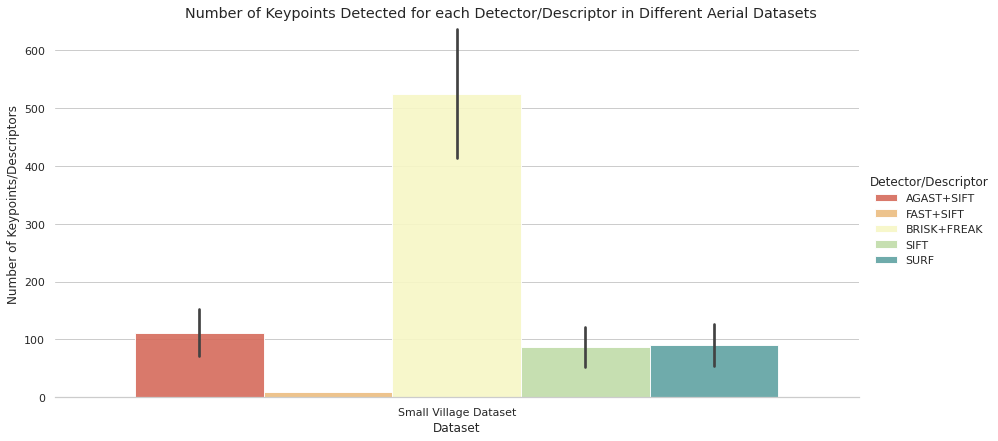

In [56]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_5, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_8_{Dataset}.png')

In [57]:
df_numkey_5.to_csv(f'drive/MyDrive/Num_Kypoints_5_{Dataset}.csv')

In [58]:
print(len(num_matches_agast))

119


Total Number of Matches Detected for each Detector+Descriptor

In [59]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_sift + num_matches_surf + num_matches_freak + num_matches_agast + num_matches_fast, 'Detector/Descriptor': ['AGAST+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['SURF']*(len_files-1)}
df_match_5 = pd.DataFrame(data=d)
df_match_5['Number of Total Matches'] = df_match_5['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

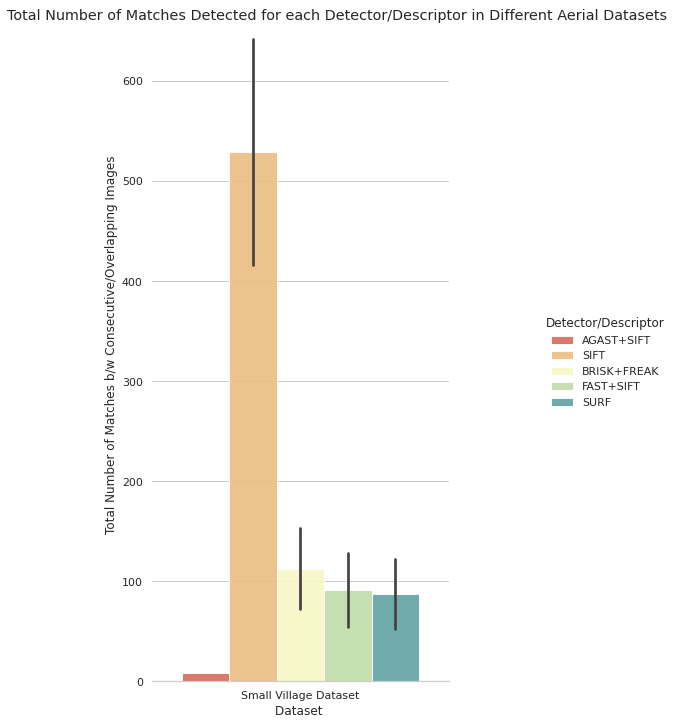

In [60]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_8_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [61]:
df_match_5['Number of Good Matches'] =  num_good_matches_sift + num_good_matches_surf + num_good_matches_freak + num_good_matches_agast + num_good_matches_fast
df_match_5['Number of Good Matches'] = df_match_5['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

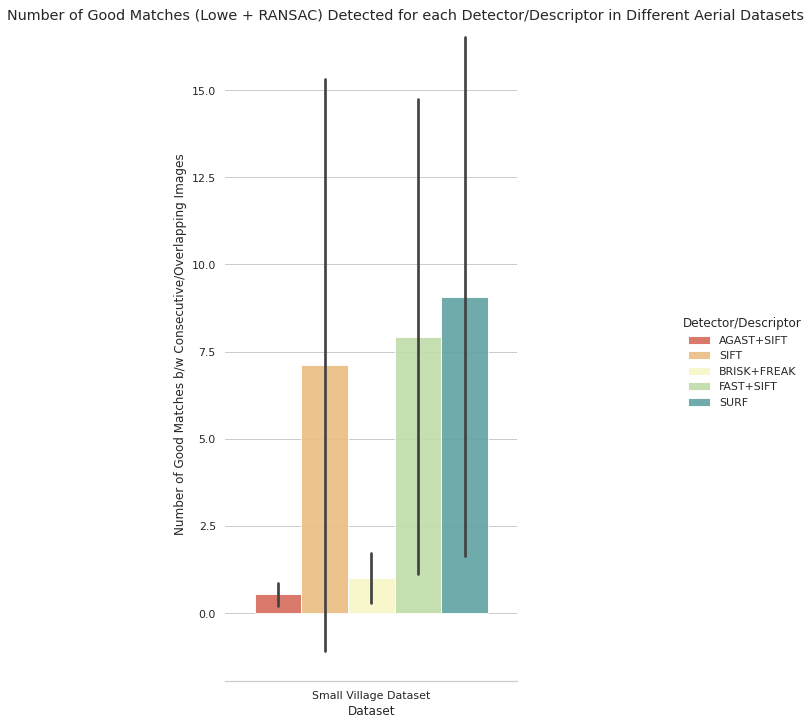

In [62]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_8.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [63]:
df_match_5['Recall Rate of Matches'] = df_match_5['Number of Good Matches']/df_match_5['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

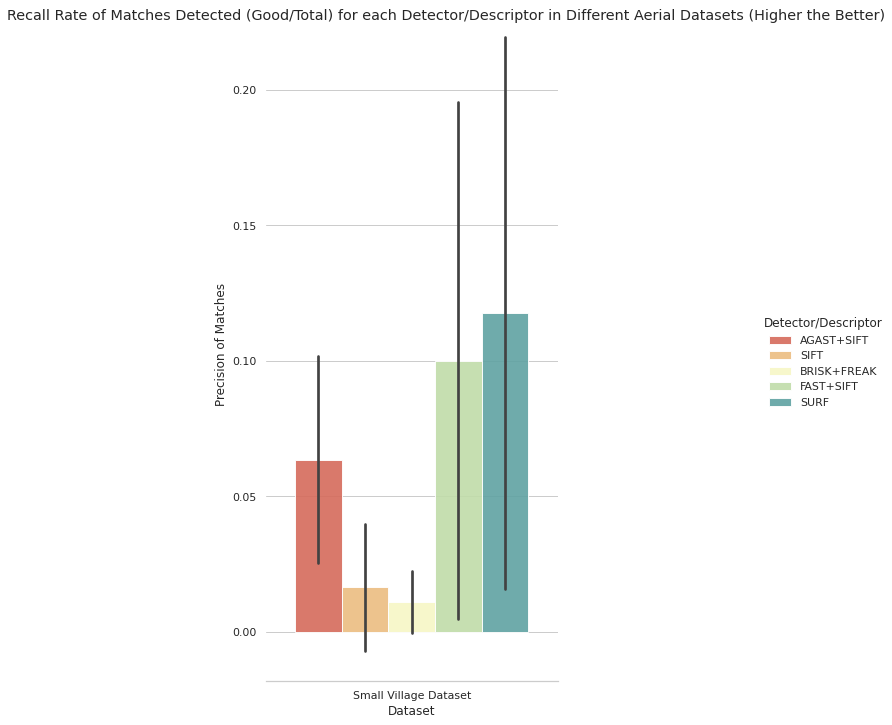

In [64]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_8.png')

1-Precision Rate for each Detector+Descriptor

In [65]:
df_match_5['1 - Precision Rate of Matches'] = (df_match_5['Number of Total Matches'] - df_match_5['Number of Good Matches'])/df_match_5['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

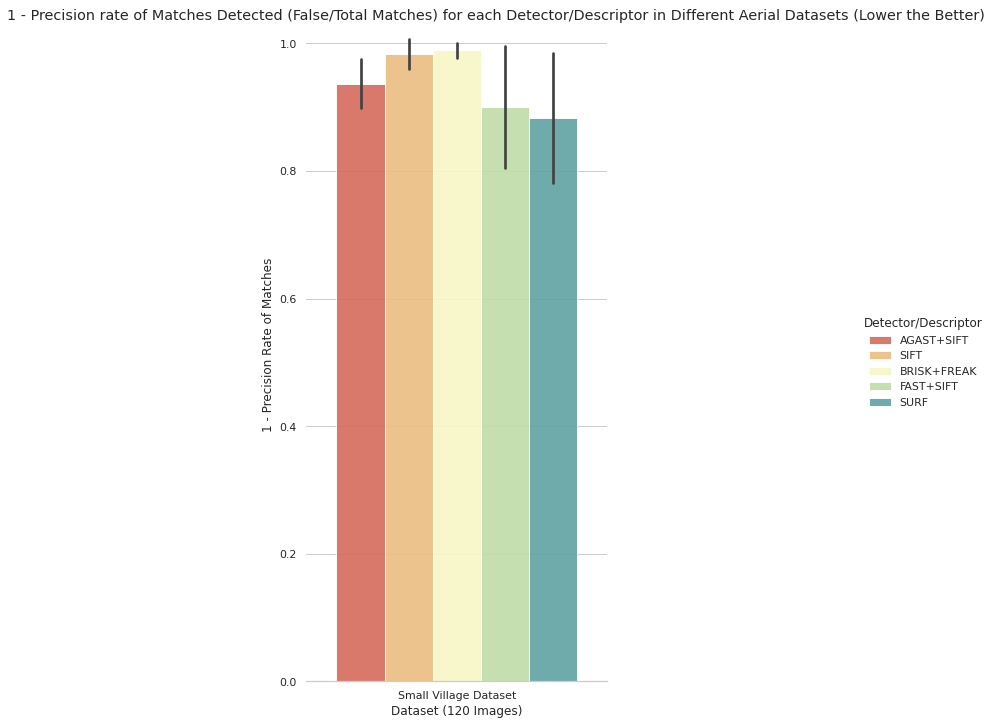

In [66]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5,kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_8.png')

F-Score for each Detector+Descriptor

In [67]:
df_match_5['F-Score'] = (2* (1 - df_match_5['1 - Precision Rate of Matches']) * df_match_5['Recall Rate of Matches'])/((1 - df_match_5['1 - Precision Rate of Matches']) + df_match_5['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

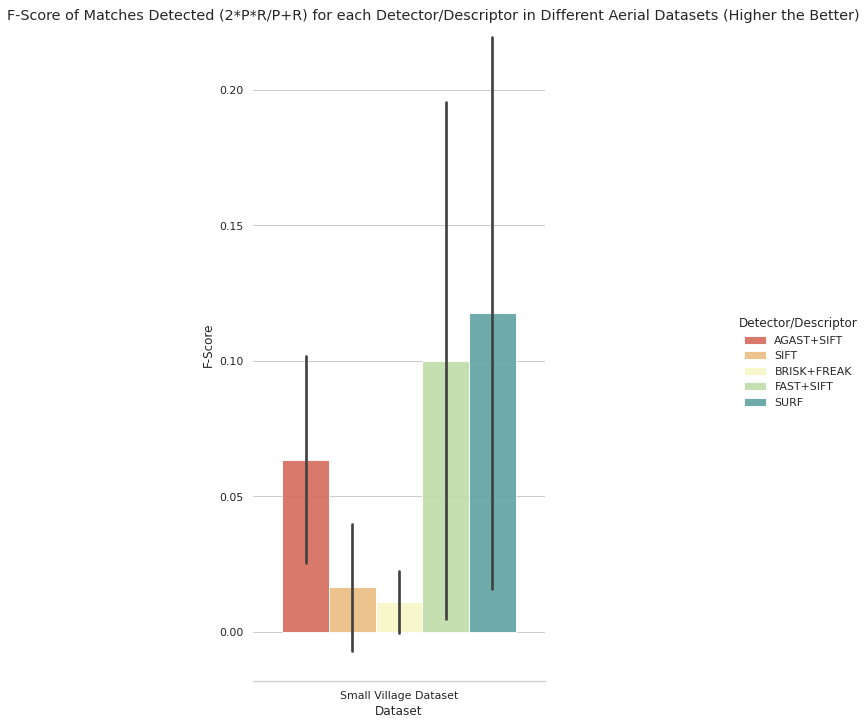

In [68]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_8.png')

In [69]:
df_match_5.to_csv('drive/MyDrive/All_metrics_5.csv')

Time for each Detector+Descriptor

In [70]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['AGAST+SIFT'] + ['FAST+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['SURF']*(1) +  ['SIFT']*(1) }
df_time_5 = pd.DataFrame(data=d)

In [71]:
print(df_time_5)

                 Dataset        Time Detector/Descriptor
0  Small Village Dataset  270.165863          AGAST+SIFT
1  Small Village Dataset   56.787172           FAST+SIFT
2  Small Village Dataset  123.098788         BRISK+FREAK
3  Small Village Dataset  130.043010                SURF
4  Small Village Dataset  484.222432                SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

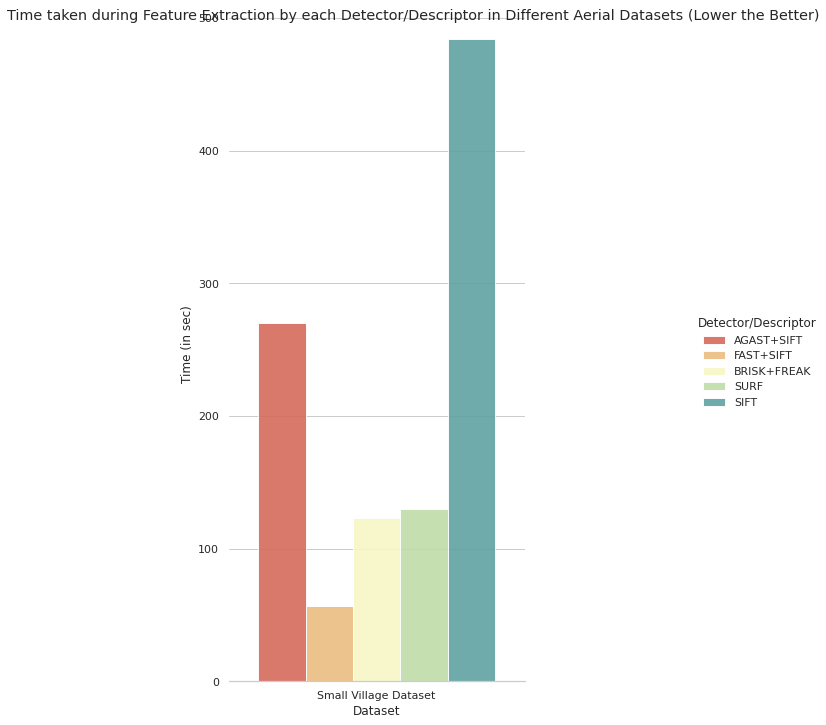

In [72]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_5, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_8.png')

In [73]:
df_time_5.to_csv('drive/MyDrive/Time_5.csv')

Stitching with CPU